# 机器学习工程师纳米学位
## 毕业项目：DeepTesla
2017年11月11日


**说明**：这个Jupter Notebook 文件包含了项目实现的代码以及相关注释。按照设计思路，将整个项目分为四个部分，分诉如下：
* **Part 1**: *数据分析与探索*。这一步骤主要是读取数据（包括csv文件和视频文件）、分析数据（如转向角度的数据分布等）。


* **Part 2**: *数据预处理*。在这部分中将前九段视频数据（转化为图片后）和对应转向角度及图片路径（转化为csv文件）作为训练数据（将划分为训练集和验证集）存储到硬盘中，将第十段视频（转化为图片后）和对应转向角度及图片路径（转化为csv文件）作为测试集存储到硬盘中。对训练数据和测试数据运用数据简化技术：剪切及重设尺寸；使用数据增加技术（之后在每个模型生成前，使用**python data generator（生成器）**来进行数据的分批次从**硬盘**导入，同时使用数据增加的方法。）：水平翻转和增加噪音等。尝试使用**VAE+GAN**增加转向角度较大的图像作为训练数据。


* **Part 3**: *利用Keras和Tensorflow训练模型并导出模型参数*。使用基准模型对训练集进行训练，并通过验证集和测试集评测模型表现。期间涉及到技术有：卷积网络和全连接网络搭建与调参，迁移学习网络搭建与参数固定和调参，RELU和ELU激活函数运用，运用Droupout层防止过拟合等。最后将训练好模型和参数保存为model.json和model.h5两个文件。


* **Part 4**: *选择最佳模型并生成最终视频*。使用时间序列图对比各模型表现，选择最终模型。并使用最终模型在测试视频epoch10_front.mkv上测试，评估人工转向与模型转向误差。最后对测试视频epoch10_front.mkv生成结果视频并保存在./output中。

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Part 1: 数据分析与探索</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

导入相关库文件
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import random
%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1.视频帧初探
</p>

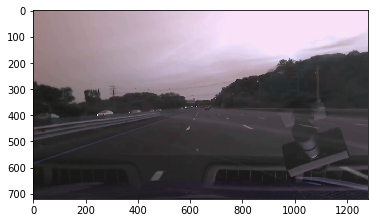

In [4]:
### 载入前置摄像头图像

frame_capture = cv2.VideoCapture('./epochs/epoch01_front.mkv')
ret, img_test = frame_capture.read()
frame_capture.release()

plt.imshow(img_test)

In [5]:
### 查看图片尺寸

img_test.shape

(720, 1280, 3)

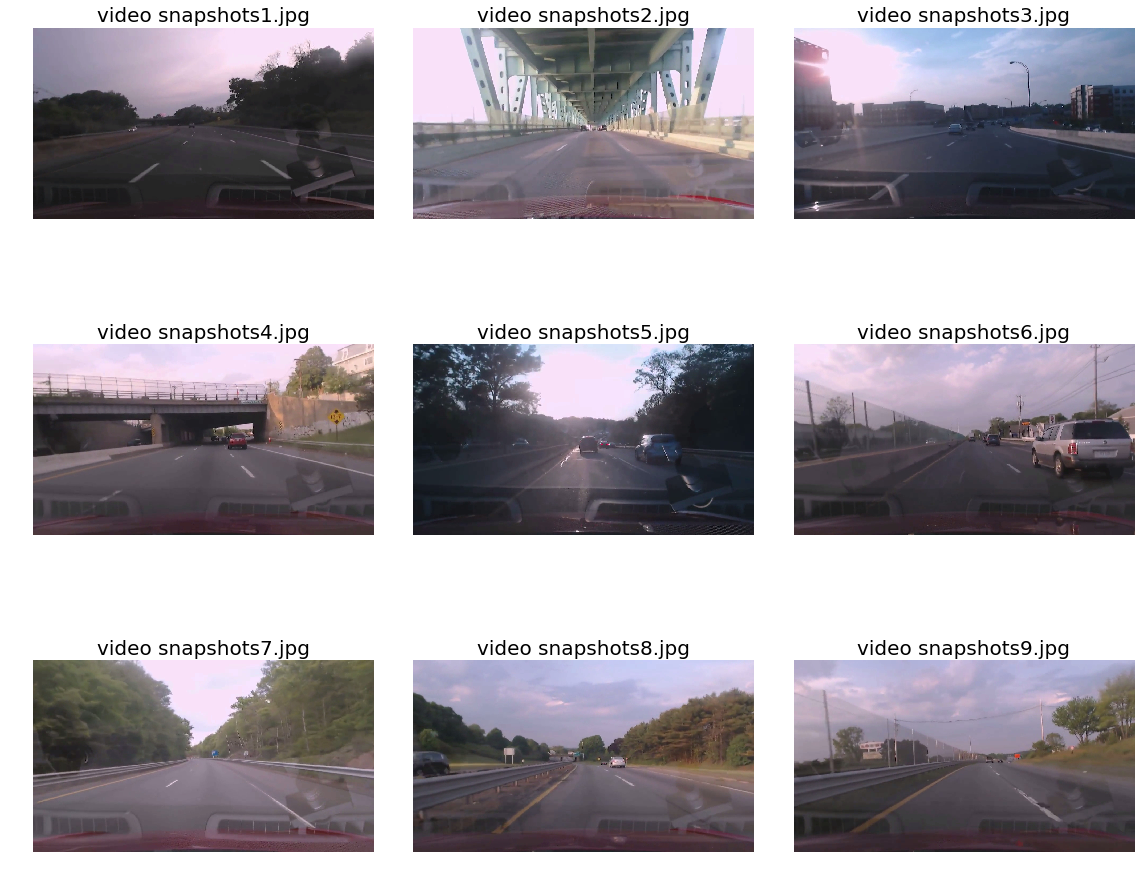

In [11]:
### 视频不同场景截图

# 读取所有视频截图图片（不同场景）并显示出来
test_images = glob.glob('./images/Video_Snapshots/*.jpg')
fig, axs = plt.subplots(3, 3, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(mpimg.imread(im))
    axs[i].set_title('video snapshots'+str(i+1)+'.jpg', fontsize=20)
    axs[i].axis('off')
# 显示所有图片 
plt.tight_layout()
plt.show()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2.转向角度分析
</p>

In [13]:
### 加载所有转向角度csv文件

csv_files = glob.glob('./epochs/*steering.csv')
csv_steers = pd.concat((pd.read_csv(f) for f in csv_files))

csv_steers.head()

frame  frame_index          ts_micro  wheel
0    0.0          NaN  1464650070285914   -1.0
1    1.0          NaN  1464650070319247   -1.0
2    2.0          NaN  1464650070352581   -1.0
3    3.0          NaN  1464650070385914   -1.0
4    4.0          NaN  1464650070419247   -1.0

In [14]:
### 查看转向角度统计信息

csv_steers.describe()

frame   frame_index      ts_micro         wheel
count  5400.000000  21600.000000  2.700000e+04  27000.000000
mean   1616.166667   1349.500000  1.464374e+15     -0.338667
std    1120.991308    779.440853  1.382617e+11      4.438301
min       0.000000      0.000000  1.464304e+15    -18.000000
25%     674.750000    674.750000  1.464304e+15     -2.500000
50%    1349.500000   1349.500000  1.464305e+15      0.000000
75%    2549.250000   2024.250000  1.464306e+15      1.500000
max    3899.000000   2699.000000  1.464650e+15     15.000000

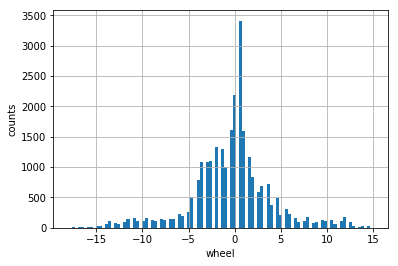

In [15]:
### 直方图查看'wheel'方向角度数据分布

wheel = csv_steers['wheel']
plt.figure
plt.grid(True)
plt.hist(wheel,100);
plt.xlabel('wheel')
plt.ylabel('counts')
plt.savefig('./images/img/Hist.png')

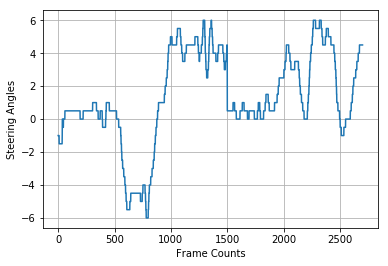

In [25]:
### 查看转向角度的时间序列图

#生成时间序列图(2700帧，90秒)
plt.figure;
plt.plot(np.arange( 0, 2700),wheel[:2700]);
plt.xlabel('Frame Counts')
plt.ylabel('Steering Angles')
plt.grid(True)
plt.savefig('./images/img/Frame_angles.png')
plt.show()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

3.视频帧和转向角度结合
</p>

In [27]:
### 读取'epoch03_front.mkv'和对应'epoch03_steering.csv'文件，

frame_capture3 = cv2.VideoCapture('./epochs/epoch03_front.mkv')

# 抓取到内存中
epoch3_imgs = []
while True:
    ret, img = frame_capture3.read()
    if not ret:
        break
    epoch3_imgs.append(img)
print ("The epoch03 images' length is:",len(epoch3_imgs))

# 读入对应csv文件
csv_wheel3 = pd.read_csv('./epochs/epoch03_steering.csv')
steering_wheel3 = csv_wheel3['wheel'].values
frame_wheel3 = csv_wheel3['frame_index'].values
print("The epoch03 wheel length is", len(steering_wheel3))

The epoch03 images' length is: 2700
The epoch03 wheel length is 2700


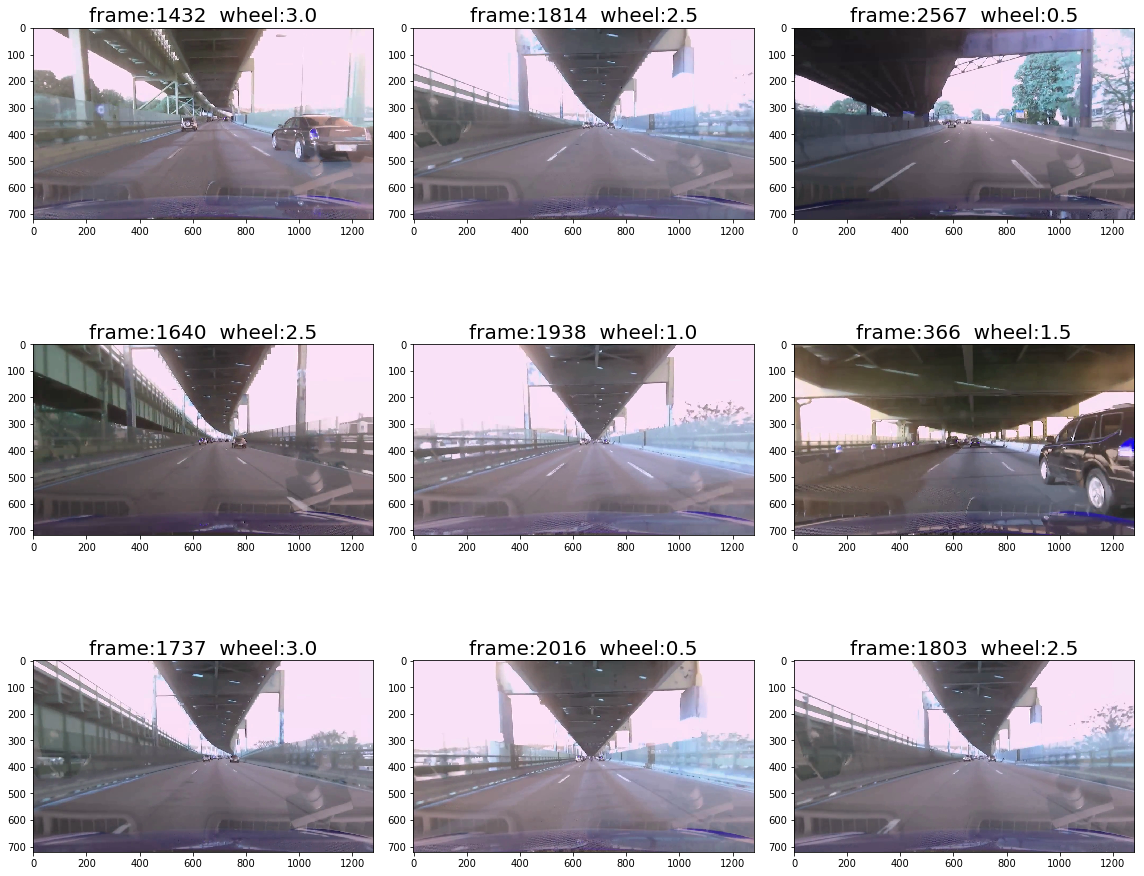

In [28]:
### 随机查看帧图片和转向策略

# 随机查看9张图片和转向角度
fig, axs = plt.subplots(3, 3, figsize=(16,14))
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()
for i in range(9):
    index = random.choice(range(len(epoch3_imgs)))
    img = epoch3_imgs[index]
    #ax = fig.add_subplot(3,3,i+1) 
    axs[i].imshow(img)
    axs[i].set_title('frame:'+ str(frame_wheel3[index]) + '  wheel:' + str(steering_wheel3[index]), fontsize=20)
    

# 显示所有图片  
plt.tight_layout()
plt.savefig('./images/img/frame_wheel.png')
plt.show()

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Part 2: 数据预处理</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
导入相关库文件
</p>

**说明**：每个part开始时，重启Kernel

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import csv
import tensorflow as tf
import pickle


# 导入自定义数据处理文件'preprocess_data'
import preprocess_data

# 导入自定义'vae_gan'
import vae_gan
z_dim = 512
VG_PATH = './vg_images/'

%matplotlib inline

Using TensorFlow backend.


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1.单张图片处理测试
</p>

(720, 1280, 3)


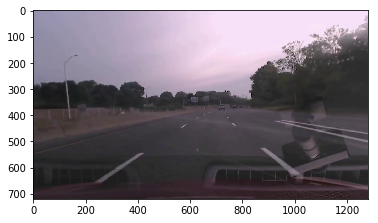

In [22]:
### <1>读取测试图片

image_test = cv2.imread('./images/img/frame_1173.jpg')
image_test = cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)
print(image_test.shape)
plt.imshow(image_test)

(80, 80, 3)


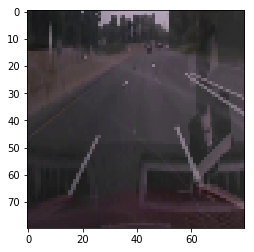

In [23]:
### <2>裁剪掉天空部分，并重设图片尺寸大小为80*80，后续用于数据选取简化（可加快模型收敛速度）

image_test_crop = image_test[300:720, 0:1280]
image_test_resize = cv2.resize(image_test_crop, (80, 80))
print(image_test_resize.shape)
plt.imshow(image_test_resize)

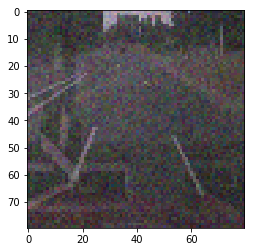

In [24]:
### <3>水平翻转图片，图片数据归一化，并给图片增加噪声，后续用于数据增加


#翻转图片
image_test_flip = cv2.flip(image_test_resize, 1)
#图片数据归一化
image_test_flip = 0.1 + (image_test_flip - 0)*(0.9 - 0.1) / 255.0
#增加噪声
noisy_img = image_test_flip + 0.05 * np.random.randn(*image_test_flip.shape)
noisy_img = np.clip(noisy_img, 0.1, 0.9)
plt.imshow(noisy_img)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2.原始训练数据与测试数据生成
</p>

In [2]:
### <1>使用 'preprocess_data' 中’load_data'将所有mkv文件转化为图像(rgb jpg格式)装入内存返回和在硬盘持久化
###(分别保存在./train_images和./test_images文件夹中)
###  并将所有对应转向角度和图片路径装入内存返回和在硬盘持久化(分别保存在./train_images和./test_images中csv文件)

#使用"1.单张图片处理测试"中的数据简化（裁剪，重设尺寸）生成基本数据
train_imgs, train_wheels = preprocess_data.load_data('train',write_to_disk=True)
test_imgs, test_wheels = preprocess_data.load_data('test',write_to_disk=True)

load data start!
The epoch1 mkv is processing
The epoch2 mkv is processing
The epoch3 mkv is processing
The epoch4 mkv is processing
The epoch5 mkv is processing
The epoch6 mkv is processing
The epoch7 mkv is processing
The epoch8 mkv is processing
The epoch9 mkv is processing
loading data filished!
load data start!
The epoch10 mkv is processing
loading data filished!


In [3]:
### <2>测试生成的训练和测试图片的shape

print("The shape of train images is", train_imgs.shape)
print("The shape of train wheels", train_wheels.shape)
print("The shape of test images is", test_imgs.shape)
print("The shape of test wheels", test_wheels.shape)

The shape of train images is (24300, 80, 80, 3)
The shape of train wheels (24300, 1)
The shape of test images is (2700, 80, 80, 3)
The shape of test wheels (2700, 1)


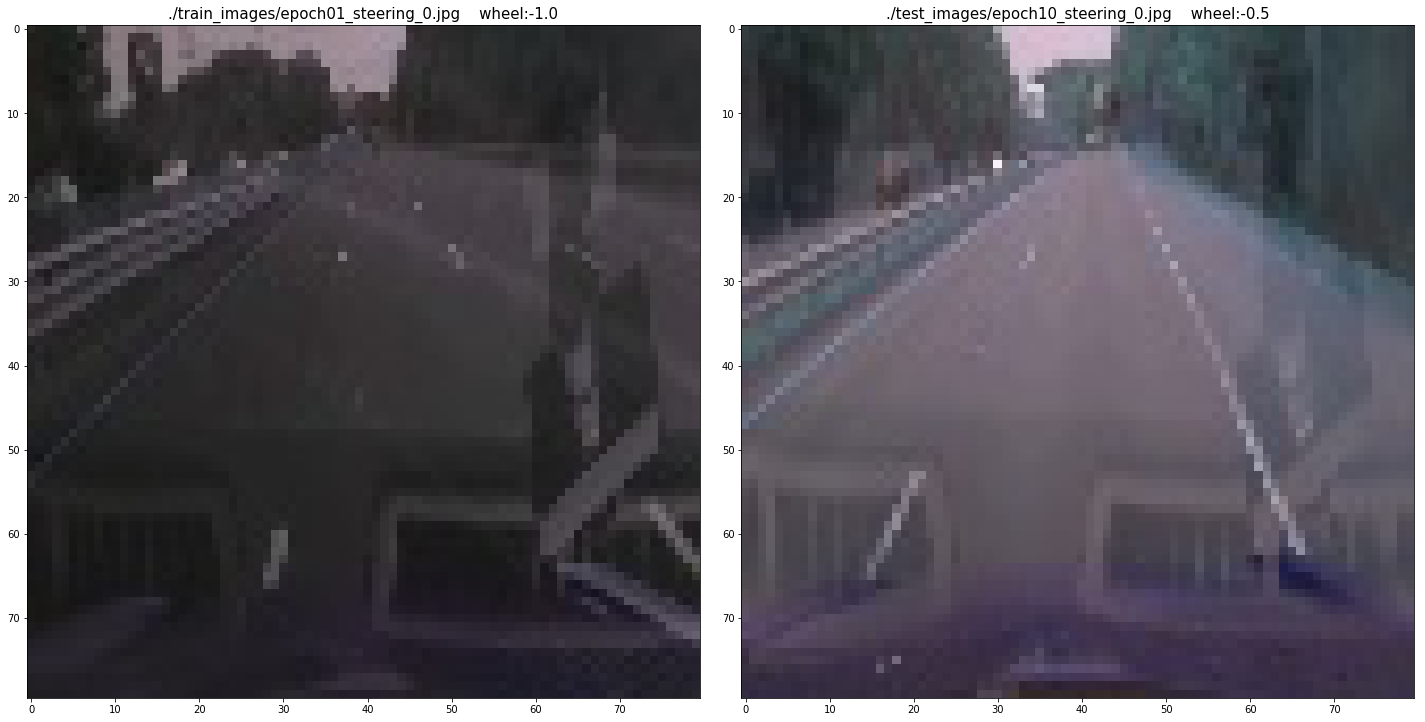

In [4]:
### <3>测试保存在硬盘上的图片和csv文件

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
img_train = plt.imread('./train_images/epoch01_steering_0.jpg')
csv_train = pd.read_csv('./train_images/train_images.csv')
ax1.imshow(img_train)
ax1.set_title(csv_train['img_path'][0]+'    wheel:'+str(csv_train['wheel'][0]), fontsize=15)
img_test = plt.imread('./test_images/epoch10_steering_0.jpg')
csv_test = pd.read_csv('./test_images/test_images.csv')
ax2.imshow(img_test)
ax2.set_title(csv_test['img_path'][0]+'    wheel:'+str(csv_test['wheel'][0]), fontsize=15)

In [1]:
### <4>对整体的数据处理策略为：
### 使用 python data generator（生成器）来进行数据的分批次从硬盘导入，同时使用数据增加的方法，对每批次进行数据增加处理（翻转和增加噪音）
### 在使用完数据增加后，数据总体将是原来的3倍
### 具体代码见文件'./preprocess_data.py中的'generator'函数

import preprocess_data
from sklearn.model_selection import train_test_split

#载入训练数据
#之后每个模型单独进行 训练数据和验证数据生成
samples = preprocess_data.read_csv('./train_images/train_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)

In [2]:
# 测试'generator'
my_output = []
for i in range(10):
    my_output = (next(train_generator))
print(my_output[0].shape)
print(my_output[1].shape)

(384, 80, 80, 3)
(384,)


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

3.使用 GAN+VAE 生成训练用数据(选做)
</p>

**说明**：

* 模型建立文章来源于：[Learning a Driving Simulator](https://arxiv.org/pdf/1608.01230.pdf)中的**Autoencoder**部分

* 参考实现代码：https://github.com/commaai/research 其中的**train_generative_model.py**及**./models/autoencoder.py, layer.py**

* 具体实现见本项目文件中**./vae_gan.py**文件中

In [4]:
### <1>建立存储中间过程文件夹

if not os.path.exists("./outputs/results_"+"autoencoder"):
    os.makedirs("./outputs/results_"+"autoencoder")
if not os.path.exists("./outputs/samples_"+"autoencoder"):
    os.makedirs("./outputs/samples_"+"autoencoder")

In [5]:
### <2>定义模型的训练生成器
### 提取转向角度小于-5或大于5的图片为训练数据（从第一部分直方图查看'wheel'方向角度数据分布中可以看出，这些数据较少）

def read_csv():
    """
    # Reading the csv file and store in the list
    """
    samples_original = []
    samples_steering = []
    with open('./train_images/train_images.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples_original.append(line)
    samples_original = samples_original[1:]
        
    # 提取转向角度小于-5或大于5的sample
    for sample in samples_original:
        if (float(sample[0]) < -5.0) or (float(sample[0]) > 5.0):
            samples_steering.append(sample)
    
    #增加转向幅度大的sample
    while True:
        if len(samples_steering) < 8000:
            #print(len(samples_steering))
            index = random.choice(range(len(samples_steering)))
            samples_steering.append(samples_steering[index])
        else:
            break
        
    return samples_steering


def generator_train(samples, batch_size=64):
    """
    # The generator of the samples
    """
    num_samples = len(samples)
    while True: #循环不停生成
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            for sample in batch_samples:
                X = cv2.imread(sample[1])
                X = cv2.resize(X, (160, 80))
                X = cv2.cvtColor(X,cv2.COLOR_BGR2RGB)
                X = X/127.5 - 1.
                X_train.append(X)
                
                
            #这里是无监督学习，不使用wheels, 使用Z作为随机输入
            X_train = np.array(X_train)
            Z = np.random.normal(0, 1, (X_train.shape[0], z_dim))
            yield Z, X_train

# 读取csv文件每一行作为一个sample
train_samles = read_csv()
#train_samles = train_samles[0:8000]
print(np.array(train_samles).shape)

# 测试'generator_train'
my_output = []
for i in range(10):
    my_output = (next(generator_train(train_samles)))
print(my_output[0].shape)
print(my_output[1].shape)

(8000, 2)
(64, 512)
(64, 80, 160, 3)


In [6]:
### <3>模型训练生成图片

with tf.Session() as sess:
    g_train, d_train, sampler, saver, loader, extras = vae_gan.get_model(sess=sess, name="autoencoder", batch_size=64, gpu=0)
    sampler_train = vae_gan.train_model("autoencoder", g_train, d_train, sampler,
                generator_train(train_samles),
                samples_per_epoch=8000,
                nb_epoch=20, verbose=1, saver=saver
                )
    
    # 训练完后使用生成图片
    new_samples = []
    for i in range(8000//64):
        output = (next(generator_train(train_samles)))
        new_sample, _ = sampler(output[0], output[1])
        new_samples.append(new_sample)

D:\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\topology.py:379: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of layers/models '


G.shape:  (64, 80, 160, 3)
E.shape:  [(64, 512), (64, 512)]
D.shape:  [(64, 1), (64, 5, 10, 512)]
Generator variables:
autoencoder/g_h0_lin_W:0
autoencoder/g_h0_lin_b:0
autoencoder/g_bn0_gamma:0
autoencoder/g_bn0_beta:0
autoencoder/g_h1/w:0
autoencoder/g_h1/biases:0
autoencoder/g_bn1_gamma:0
autoencoder/g_bn1_beta:0
autoencoder/g_h2/w:0
autoencoder/g_h2/biases:0
autoencoder/g_bn2_gamma:0
autoencoder/g_bn2_beta:0
autoencoder/g_h3/w:0
autoencoder/g_h3/biases:0
autoencoder/g_bn3_gamma:0
autoencoder/g_bn3_beta:0
autoencoder/g_h4/w:0
autoencoder/g_h4/biases:0
Discriminator variables:
autoencoder/d_h0_conv_W:0
autoencoder/d_h0_conv_b:0
autoencoder/d_h1_conv_W:0
autoencoder/d_h1_conv_b:0
autoencoder/d_bn1_gamma:0
autoencoder/d_bn1_beta:0
autoencoder/d_h2_conv_W:0
autoencoder/d_h2_conv_b:0
autoencoder/d_bn2_gamma:0
autoencoder/d_bn2_beta:0
autoencoder/d_h3_conv_W:0
autoencoder/d_h3_conv_b:0
autoencoder/d_bn3_gamma:0
autoencoder/d_bn3_beta:0
autoencoder/d_h3_lin_W:0
autoencoder/d_h3_lin_b:0
Enc

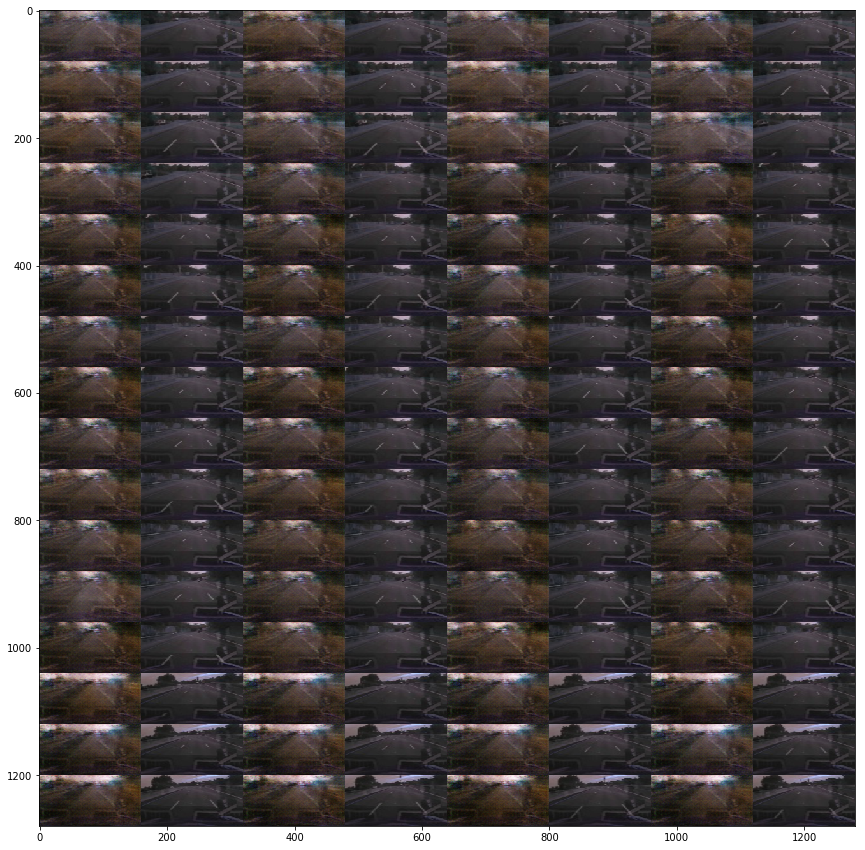

In [7]:
### <4>保存和查看生成图片
### 图中奇数列（从1开始计数）为生成图片，偶数列（从2开始）为原始图片。生成图片基本呈现了原始图片特征并有细微差别（转向角度大体没变），
### 后面尝试使用训练
### 原始模型进行了200次训练，这里因时间原因和练习目的仅训练20次。后期可增加训练次数进行优化

# 保存新生成图像和相关信息
pickle.dump(new_samples, open('./images/vg_images.p', 'wb'))
pickle.dump(train_samles, open('./images/train_samles.p', 'wb'))

#查看新生成图片
image_test = cv2.imread('./outputs/samples_autoencoder/train_19_0.png')
image_test = cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15)) 
plt.imshow(image_test)

(8000, 80, 160, 3)
(8000, 2)


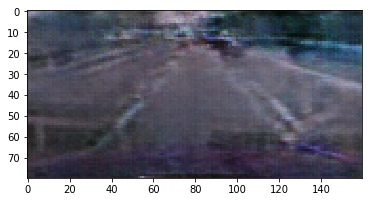

In [8]:
### <5>载入新生成图片和相关信息并测试

# 载入数据
imgs_data = pickle.load(open('./images/vg_images.p', 'rb'))
wheels_data = pickle.load(open('./images/train_samles.p', 'rb'))

# 查看图片
new_images = np.array(imgs_data).reshape((-1,80,160,3))
print(new_images.shape)
print(np.array(wheels_data).shape)
new_images = vae_gan.inverse_transform(new_images)
plt.imshow(new_images[799])

In [9]:
### <6>将图片(以rgb jpg格式)和转向角度及图片路径(以csv文件)保存到硬盘'./vg_images'文件夹中

preprocess_data.write_vg_images(new_images, wheels_data)

Write vg images success!


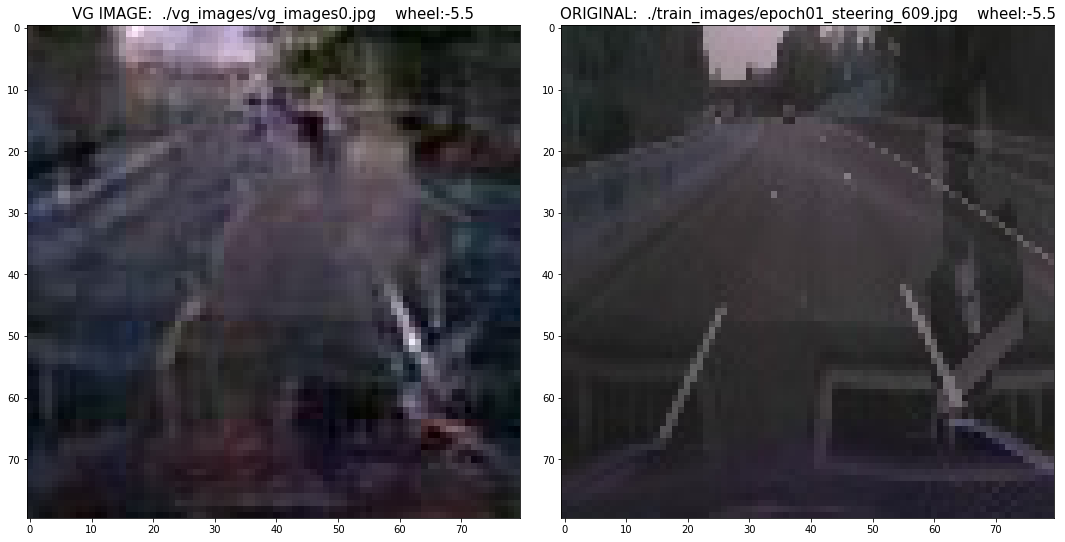

In [10]:
### <7>测试保存在硬盘上新生成csv文件和原文件对比

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))
f.tight_layout()
img_vg = plt.imread('./vg_images/vg_images0.jpg')
csv_vg = pd.read_csv('./vg_images/vg_images.csv')
ax1.imshow(img_vg)
ax1.set_title('VG IMAGE:  '+csv_vg['img_path'][0]+'    wheel:'+str(csv_vg['wheel'][0]), fontsize=15)
img_orginal = plt.imread(wheels_data[0][1])
ax2.imshow(img_orginal)
ax2.set_title('ORIGINAL:  '+wheels_data[0][1]+'    wheel:'+wheels_data[0][0], fontsize=15)

**数据处理方式说明**：之后在每个模型生成前，使用**python data generator（生成器）**来进行数据的分批次从**硬盘**导入（先读取csv文件，再根据文件中的路径读取图片），同时使用数据增加的方法，对每批次进行数据增加处理。

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Part 3: 训练模型</p><br>

**说明**：每个model开始时，重启Kernel

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1.NVIDIA end-to-end model
</p>

#### (1) Benchmark (基准模型)

In [1]:
### <1>用generator 生成NVIDIA model训练数据

import preprocess_data
from sklearn.model_selection import train_test_split

#载入训练数据
samples = preprocess_data.read_csv('./train_images/train_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)

In [2]:
### <2>建立NVIDIA model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda

def Nvidia_model():
    """
    Nvidia model:referenced https://arxiv.org/pdf/1604.07316v1.pdf
    """
    print("Nvidia-------------")
    model = Sequential()
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu', input_shape=(80,80,3)))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    return model

Using TensorFlow backend.


In [3]:
Nvidia_model().summary()

Nvidia-------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 38, 38, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 17, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 7, 7, 48)      43248       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 5, 5, 64)      27712       convolution2d_3[0][0]            
_______________________________________________________________________

In [4]:
### <3>NVIDIA model模型训练


model = Nvidia_model()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=10)

Nvidia-------------
Epoch 1/10
58320/58320 [==============================] - 41s - loss: 17.8832 - val_loss: 10.7253
Epoch 2/10
58320/58320 [==============================] - 38s - loss: 7.3714 - val_loss: 4.8491
Epoch 3/10
58320/58320 [==============================] - 36s - loss: 3.8005 - val_loss: 2.4994
Epoch 4/10
58320/58320 [==============================] - 37s - loss: 2.1176 - val_loss: 1.5325
Epoch 5/10
58320/58320 [==============================] - 37s - loss: 1.3325 - val_loss: 1.1606
Epoch 6/10
58320/58320 [==============================] - 37s - loss: 1.0151 - val_loss: 0.8715
Epoch 7/10
58320/58320 [==============================] - 38s - loss: 0.8035 - val_loss: 0.8606
Epoch 8/10
58320/58320 [==============================] - 38s - loss: 0.6615 - val_loss: 0.7174
Epoch 9/10
58320/58320 [==============================] - 37s - loss: 0.5866 - val_loss: 0.5787
Epoch 10/10
58320/58320 [==============================] - 36s - loss: 0.5361 - val_loss: 0.5013


load data start!
The epoch10 mkv is processing
loading data filished!
2700/2700 [==============================] - 1s     

 Test loss is:8.861750322977702


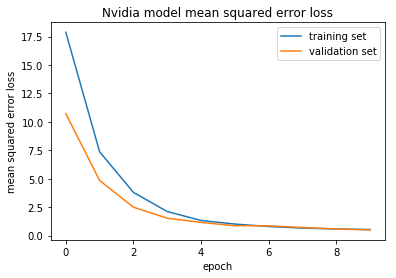

In [5]:
### <4>分析结果
import preprocess_data
import matplotlib.pyplot as plt

#读取测试测试文件
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

# 测试模型在测试文件上表现
test_loss= model.evaluate(test_imgs, test_wheels, batch_size=128)
print('\n Test loss is:{}'.format(test_loss))

# 查看训练集和验证集loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Nvidia model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [6]:
### <5>保存model
import os

# model文件和json文件存储路径
model_saved_path = os.path.join('./models/', "nvidia_model.h5")
json_saved_path = os.path.join('./models/', "nvidia_model.json")

# 存储json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# 存储model
model.save(model_saved_path)

In [14]:
### 选做：<6>增加vg+gan生成图片到训练数据

#载入训练数据
samples = preprocess_data.read_csv('./train_images/train_images.csv')
vg_samples = preprocess_data.read_csv('./vg_images/vg_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_samples = train_samples + vg_samples
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)


model_plus = Nvidia_model()
model_plus.compile(loss='mse', optimizer='adam')
history_object = model_plus.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=5)

Nvidia-------------
Epoch 1/5
82320/82320 [==============================] - 56s - loss: 38.1551 - val_loss: 20.3620
Epoch 2/5
82320/82320 [==============================] - 53s - loss: 40.7791 - val_loss: 20.3723
Epoch 3/5
82320/82320 [==============================] - 53s - loss: 40.5858 - val_loss: 20.3775
Epoch 4/5
82320/82320 [==============================] - 53s - loss: 41.5649 - val_loss: 20.3687
Epoch 5/5
82320/82320 [==============================] - 53s - loss: 41.4422 - val_loss: 20.3613


In [15]:
# 测试模型在测试文件上表现
test_loss= model_plus.evaluate(test_imgs, test_wheels, batch_size=128)
test_imgs = preprocess_data.nomorlize_image(test_imgs)
print('Test loss is:{}'.format(test_loss))

2688/2700 [============================>.] - ETA: 0sTest loss is:7.497045198016696


**分析**：在加入vae+gan模型生成数据后，原始模型表现在训练集和验证集不能很好收敛，但在测试集上表现变好（说明模型识能力有所增强）。但总体来说还是生成图片模型vae+gan训练次数太少，所以后期不加入vae+gan模型生成数据，留待后续优化。

#### (2) Refined Model (改进模型:ELU, Batch normalization, Weight initial, MaxPooling, BatchNormalization, Dropout)

In [1]:
### <1>用generator 生成NVIDIA refined model训练数据

import preprocess_data
from sklearn.model_selection import train_test_split

#载入训练数据
samples = preprocess_data.read_csv('./train_images/train_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)

In [2]:
### <2>建立NVIDIA refined model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda, BatchNormalization, MaxPooling2D

def Nvidia_refined_model():
    """
    Nvidia refined model
    """
    print("Nvidia-------------")
    model = Sequential()
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal',input_shape=(80,80,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())  
    
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(64,3,3,activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(64,3,3,activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1164, activation='elu',init='he_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(100, activation='elu',init='he_normal'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50, activation='elu',init='he_normal'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='elu',init='he_normal'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))

    return model

Using TensorFlow backend.


In [3]:
Nvidia_refined_model().summary()

Nvidia-------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 40, 40, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 40, 40, 24)    96          convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 20, 20, 24)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 10, 36)    21636       maxpooling2d_1[0][0]             
_______________________________________________________________________

In [4]:
### <3>NVIDIA refined model模型训练


model = Nvidia_refined_model()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=10)

Nvidia-------------
Epoch 1/10
58320/58320 [==============================] - 41s - loss: 12.3596 - val_loss: 16.3098
Epoch 2/10
58320/58320 [==============================] - 35s - loss: 4.8543 - val_loss: 7.3601
Epoch 3/10
58320/58320 [==============================] - 35s - loss: 3.2042 - val_loss: 2.5542
Epoch 4/10
58320/58320 [==============================] - 36s - loss: 2.5189 - val_loss: 1.3969
Epoch 5/10
58320/58320 [==============================] - 38s - loss: 2.1358 - val_loss: 1.1753
Epoch 6/10
58320/58320 [==============================] - 37s - loss: 1.8533 - val_loss: 1.0263
Epoch 7/10
58320/58320 [==============================] - 36s - loss: 1.7034 - val_loss: 1.3407
Epoch 8/10
58320/58320 [==============================] - 35s - loss: 1.5898 - val_loss: 0.8573
Epoch 9/10
58320/58320 [==============================] - 35s - loss: 1.4742 - val_loss: 0.7142
Epoch 10/10
58320/58320 [==============================] - 37s - loss: 1.4000 - val_loss: 0.8484


load data start!
The epoch10 mkv is processing
loading data filished!
2700/2700 [==============================] - 0s     

 Test loss is:4.479728813877812


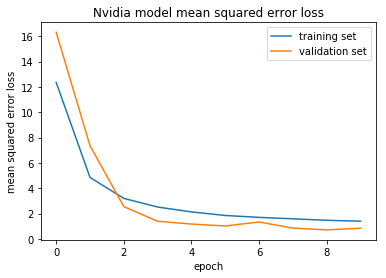

In [5]:
### <4>分析结果
import preprocess_data
import matplotlib.pyplot as plt

#读取测试测试文件
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

# 测试模型在测试文件上表现
test_loss= model.evaluate(test_imgs, test_wheels, batch_size=128)
print('\n Test loss is:{}'.format(test_loss))

# 查看训练集和验证集loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Nvidia model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [6]:
### <5>保存model
import os

# model文件和json文件存储路径
model_saved_path = os.path.join('./models/', "nvidia_refined_model.h5")
json_saved_path = os.path.join('./models/', "nvidia_refined_model.json")

# 存储json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# 存储model
model.save(model_saved_path)

#### (3) Refined Model + 转向角度数据增加

In [1]:
### <1>用generator 生成NVIDIA refined model训练数据
import csv
import preprocess_data
import random
from sklearn.model_selection import train_test_split

#修改读取samples的function'read_csv',增加转向角度小于-5或大于5的sample
#原samples大小为24300，现增加为40000
def read_csv_add():
    """
    # Reading the csv file and store in the list
    """
    samples_original = []
    samples_steering = []
    with open('./train_images/train_images.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples_original.append(line)
    samples_original = samples_original[1:]
        
    # 提取转向角度小于-5或大于5的sample
    for sample in samples_original:
        if (float(sample[0]) < -5.0) or (float(sample[0]) > 5.0):
            samples_steering.append(sample)
    
    #增加转向幅度大的sample
    while True:
        if len(samples_original) < 40000:
            #print(len(samples_steering))
            index = random.choice(range(len(samples_steering)))
            samples_original.append(samples_steering[index])
        else:
            break
        
    return samples_original

#载入训练数据
samples = read_csv_add()
print(len(samples))

40000


In [2]:
# 划分训练集和验证集
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)

In [3]:
### <2>建立NVIDIA refined model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda, BatchNormalization, MaxPooling2D

def Nvidia_refined_model():
    """
    Nvidia refined model
    """
    print("Nvidia-------------")
    model = Sequential()
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal',input_shape=(80,80,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())  
    
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(64,3,3,activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(64,3,3,activation='elu',border_mode='same',init='he_normal'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1164, activation='elu',init='he_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(100, activation='elu',init='he_normal'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50, activation='elu',init='he_normal'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='elu',init='he_normal'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))

    return model

Using TensorFlow backend.


In [4]:
Nvidia_refined_model().summary()

Nvidia-------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 40, 40, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 40, 40, 24)    96          convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 20, 20, 24)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 10, 36)    21636       maxpooling2d_1[0][0]             
_______________________________________________________________________

In [5]:
### <3>NVIDIA refined model模型训练


model = Nvidia_refined_model()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=10)

Nvidia-------------
Epoch 1/10
96000/96000 [==============================] - 265s - loss: 12.0565 - val_loss: 24.0982
Epoch 2/10
96000/96000 [==============================] - 61s - loss: 4.1674 - val_loss: 3.9496
Epoch 3/10
96000/96000 [==============================] - 61s - loss: 3.1119 - val_loss: 1.3425
Epoch 4/10
96000/96000 [==============================] - 60s - loss: 2.6613 - val_loss: 1.1643
Epoch 5/10
96000/96000 [==============================] - 62s - loss: 2.3794 - val_loss: 0.8630
Epoch 6/10
96000/96000 [==============================] - 61s - loss: 2.1848 - val_loss: 0.7885
Epoch 7/10
96000/96000 [==============================] - 62s - loss: 2.0637 - val_loss: 0.6422
Epoch 8/10
96000/96000 [==============================] - 62s - loss: 1.9930 - val_loss: 0.8113
Epoch 9/10
96000/96000 [==============================] - 63s - loss: 1.8898 - val_loss: 0.5942
Epoch 10/10
96000/96000 [==============================] - 63s - loss: 1.8166 - val_loss: 0.5717


load data start!
The epoch10 mkv is processing
loading data filished!
2700/2700 [==============================] - 0s     

 Test loss is:3.2823049792536985


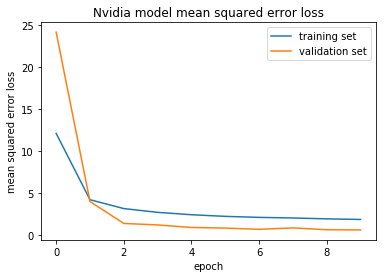

In [6]:
### <4>分析结果
import preprocess_data
import matplotlib.pyplot as plt

#读取测试测试文件
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

# 测试模型在测试文件上表现
test_loss= model.evaluate(test_imgs, test_wheels, batch_size=128)
print('\n Test loss is:{}'.format(test_loss))

# 查看训练集和验证集loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Nvidia model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [7]:
### <5>保存model
import os

# model文件和json文件存储路径
model_saved_path = os.path.join('./models/', "nvidia_ra_model.h5")
json_saved_path = os.path.join('./models/', "nvidia_ra_model.json")

# 存储json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# 存储model
model.save(model_saved_path)

**分析**：增加转向幅度大的sample后，训练数据达到96000，模型在验证集和测试集上有所提升。说明增加后对模型是有帮助的，同时还需要结合时序图来分析对比预测转向和人工转向的差别。

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2.VGG16 + Nvidia model
</p>

#### (1)notop + noblocks

In [1]:
### <1>.用generator生成VGG16 + Nvidia model 训练数据

import preprocess_data
from sklearn.model_selection import train_test_split

#载入训练数据
samples = preprocess_data.read_csv('./train_images/train_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=64)
validation_generator = preprocess_data.generator(validation_samples, batch_size=64)

In [2]:
### <2>VGG16 + Nvidia model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16

def Vgg16_first_model():
    """
    Vgg16 model
    """
    print("Vgg16---------------")
    input_shape = (80,80,3)
    input_tensor = Input(shape=input_shape)

    base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='elu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='elu')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(1, init='zero')(x)

    # the model we will train
    model = Model(input=base_model.input, output=predictions)

    return model

Using TensorFlow backend.


In [3]:
Vgg16_first_model().summary()

Vgg16---------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 80, 80, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 80, 80, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 40, 40, 64)    0           block1_conv2[0][0]               
______________________________________________________________________

In [6]:
### <3>VGG16 + Nvidia模型训练
from keras.optimizers import Adam


model = Vgg16_first_model()

# 不选择blocks训练
for layer in model.layers[:19]:
    layer.trainable = False
for layer in model.layers[19:]:
    layer.trainable = True  

# Default parameters follow those provided in the original paper.
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.6)
model.compile(optimizer=opt, loss='mse')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=5)

Vgg16---------------
Epoch 1/5
58320/58320 [==============================] - 109s - loss: 21.0579 - val_loss: 21.4298
Epoch 2/5
58320/58320 [==============================] - 108s - loss: 21.0543 - val_loss: 21.4272
Epoch 3/5
58320/58320 [==============================] - 108s - loss: 21.0524 - val_loss: 21.4257
Epoch 4/5
58320/58320 [==============================] - 108s - loss: 21.0525 - val_loss: 21.4244
Epoch 5/5
58320/58320 [==============================] - 108s - loss: 21.0515 - val_loss: 21.4235


分析：可以看出，不加入block进行训练，原始参数并不能很好提取图像的特征，导致模型无法很好的收敛。所以需要加入卷积层进行训练。

#### (2)notop + top2 bolocks

In [2]:
### <1>.用generator生成VGG16 + Nvidia model 训练数据

import preprocess_data
from sklearn.model_selection import train_test_split

#载入训练数据
samples = preprocess_data.read_csv('./train_images/train_images.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=64)
validation_generator = preprocess_data.generator(validation_samples, batch_size=64)

In [3]:
### <2>VGG16 + Nvidia model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16

def Vgg16_transfer_model():
    """
    Vgg16 model
    """
    print("Vgg16---------------")
    input_shape = (80,80,3)
    input_tensor = Input(shape=input_shape)

    base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='elu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='elu')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(1, init='zero')(x)

    # the model we will train
    model = Model(input=base_model.input, output=predictions)

    return model

Using TensorFlow backend.


In [4]:
Vgg16_transfer_model().summary()

Vgg16---------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 80, 80, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 80, 80, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 40, 40, 64)    0           block1_conv2[0][0]               
______________________________________________________________________

In [4]:
### <3>VGG16 + Nvidia模型训练
from keras.optimizers import Adam


model = Vgg16_transfer_model()

# 选择top2 blocks训练
for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True  

# Default parameters follow those provided in the original paper.
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.6)
model.compile(optimizer=opt, loss='mse')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=10)

Vgg16---------------
Epoch 1/10
58320/58320 [==============================] - 172s - loss: 14.5413 - val_loss: 10.7658
Epoch 2/10
58320/58320 [==============================] - 165s - loss: 10.0365 - val_loss: 8.2215
Epoch 3/10
58320/58320 [==============================] - 165s - loss: 8.2899 - val_loss: 7.0026
Epoch 4/10
58320/58320 [==============================] - 165s - loss: 7.2961 - val_loss: 6.2059
Epoch 5/10
58320/58320 [==============================] - 166s - loss: 6.6702 - val_loss: 5.7412
Epoch 6/10
58320/58320 [==============================] - 166s - loss: 6.2682 - val_loss: 5.3753
Epoch 7/10
58320/58320 [==============================] - 166s - loss: 5.9600 - val_loss: 5.1232
Epoch 8/10
58320/58320 [==============================] - 165s - loss: 5.6579 - val_loss: 4.8521
Epoch 9/10
58320/58320 [==============================] - 165s - loss: 5.4689 - val_loss: 4.6580
Epoch 10/10
58320/58320 [==============================] - 165s - loss: 5.3162 - val_loss: 4.5624


load data start!
The epoch10 mkv is processing
loading data filished!
2700/2700 [==============================] - 6s     

 Test loss is:2.782660860132288


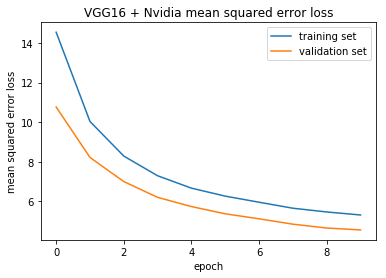

In [5]:
### <4>分析结果
import preprocess_data
import matplotlib.pyplot as plt

#读取测试测试文件
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

# 测试模型在测试文件上表现
test_loss= model.evaluate(test_imgs, test_wheels, batch_size=128)
print('\n Test loss is:{}'.format(test_loss))

# 查看训练集和验证集loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('VGG16 + Nvidia mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [6]:
### <5>保存model
import os

# model文件和json文件存储路径
model_saved_path = os.path.join('./models/', "vgg16_model.h5")
json_saved_path = os.path.join('./models/', "vgg16_model.json")

# 存储json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# 存储model
model.save(model_saved_path)

#### (3)notop + top2 bolocks + 转向角度数据增加

In [1]:
### <1>用generator 生成Vgg16 + Nvidia 训练数据
import csv
import preprocess_data
import random
from sklearn.model_selection import train_test_split

#修改读取samples的function'read_csv',增加转向角度小于-5或大于5的sample
#原samples大小为24300，现增加为40000
def read_csv_add():
    """
    # Reading the csv file and store in the list
    """
    samples_original = []
    samples_steering = []
    with open('./train_images/train_images.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples_original.append(line)
    samples_original = samples_original[1:]
        
    # 提取转向角度小于-5或大于5的sample
    for sample in samples_original:
        if (float(sample[0]) < -5.0) or (float(sample[0]) > 5.0):
            samples_steering.append(sample)
    
    #增加转向幅度大的sample
    while True:
        if len(samples_original) < 40000:
            #print(len(samples_steering))
            index = random.choice(range(len(samples_steering)))
            samples_original.append(samples_steering[index])
        else:
            break
        
    return samples_original

#载入训练数据
samples = read_csv_add()
print(len(samples))

40000


In [2]:
# 划分训练集和验证集
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = preprocess_data.generator(train_samples, batch_size=128)
validation_generator = preprocess_data.generator(validation_samples, batch_size=128)

In [3]:
### <2>VGG16 + Nvidia model

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Lambda, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16

def Vgg16_transfer_model():
    """
    Vgg16 model
    """
    print("Vgg16---------------")
    input_shape = (80,80,3)
    input_tensor = Input(shape=input_shape)

    base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='elu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='elu')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(1, init='zero')(x)

    # the model we will train
    model = Model(input=base_model.input, output=predictions)

    return model

Using TensorFlow backend.


In [4]:
Vgg16_transfer_model().summary()

Vgg16---------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 80, 80, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 80, 80, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 40, 40, 64)    0           block1_conv2[0][0]               
______________________________________________________________________

In [5]:
### <3>VGG16 + Nvidia模型训练
from keras.optimizers import Adam


model = Vgg16_transfer_model()

# 选择top2 blocks训练
for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True  

# Default parameters follow those provided in the original paper.
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.6)
model.compile(optimizer=opt, loss='mse')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
                                     len(train_samples)*3, validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3,nb_epoch=10)

Vgg16---------------
Epoch 1/10
96000/96000 [==============================] - 262s - loss: 19.4276 - val_loss: 8.1972
Epoch 2/10
96000/96000 [==============================] - 257s - loss: 8.1509 - val_loss: 5.4931
Epoch 3/10
96000/96000 [==============================] - 257s - loss: 6.5458 - val_loss: 4.6628
Epoch 4/10
96000/96000 [==============================] - 257s - loss: 5.7366 - val_loss: 4.1017
Epoch 5/10
96000/96000 [==============================] - 258s - loss: 5.3208 - val_loss: 3.7532
Epoch 6/10
96000/96000 [==============================] - 258s - loss: 4.9637 - val_loss: 3.5392
Epoch 7/10
96000/96000 [==============================] - 257s - loss: 4.7431 - val_loss: 3.3827
Epoch 8/10
96000/96000 [==============================] - 258s - loss: 4.5388 - val_loss: 3.2475
Epoch 9/10
96000/96000 [==============================] - 258s - loss: 4.3775 - val_loss: 3.1380
Epoch 10/10
96000/96000 [==============================] - 258s - loss: 4.2552 - val_loss: 2.9988


load data start!
The epoch10 mkv is processing
loading data filished!
2700/2700 [==============================] - 5s     

 Test loss is:3.54451801971153


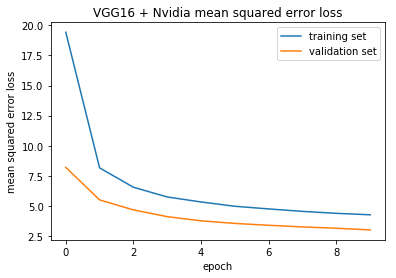

In [6]:
### <4>分析结果
import preprocess_data
import matplotlib.pyplot as plt

#读取测试测试文件
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

# 测试模型在测试文件上表现
test_loss= model.evaluate(test_imgs, test_wheels, batch_size=128)
print('\n Test loss is:{}'.format(test_loss))

# 查看训练集和验证集loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('VGG16 + Nvidia mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [7]:
### <5>保存model
import os

# model文件和json文件存储路径
model_saved_path = os.path.join('./models/', "vgg16_add_model.h5")
json_saved_path = os.path.join('./models/', "vgg16_add_model.json")

# 存储json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# 存储model
model.save(model_saved_path)

**分析**：同样，增加转向幅度大的sample后，训练数据达到96000，模型在验证集上有所提升，但测试集变化不大。再次说明数据增加后对模型帮助是有限的，同时还需要结合时序图来分析对比预测转向和人工转向的差别。

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

3.CNN+RNN seq2seq model （选做）
</p>

**说明**：

* 模型建立来源于：[UDACITY 的开源挑战项目 9 "Teaching a Machine to Steer a Car"](https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c)，其中第一名"Team Komanda"建立的seq2seq模型。

* 参考实现代码：https://github.com/udacity/self-driving-car/tree/master/steering-models/community-models/komanda  的 **solution-komanda.ipynb**文件

* 作为选做项目，按照原代码处理数据方式，并没有进行**数据增加处理技术**，直接使用原图片进行模型训练

In [1]:
### <1>导入使用的库文件

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import csv
slim = tf.contrib.slim

In [2]:
### <2>定义相关宏参数

SEQ_LEN = 10 
BATCH_SIZE = 4 
LEFT_CONTEXT = 5

# 这些是输入图片的维度
HEIGHT = 80
WIDTH = 80
CHANNELS = 3 # RGB

# LSTM 保存模型 'state'(状态的参数)
RNN_SIZE = 32
RNN_PROJ = 32

# 要预测的是转向角度信息
CSV_HEADER = "timestamp,index,angle".split(",")
OUTPUTS = [CSV_HEADER[2]] 
OUTPUT_DIM = len(OUTPUTS)

In [3]:
### <3>输入输出的格式定义
### 通过读取csv文件生成形如 BATCH_SIZE x SEQ_LEN 矩阵的samples
### 然后使用'BatchGenerator'生成器每个sequence 向前看 LEFT_CONTEXT 的图片， 
### 通过生成器生成形如 [BATCH_SIZE, LEFT_CONTEXT + SEQ_LEN, HEIGHT, WIDTH, CHANNELS] 矩阵的训练数据

import cv2
class BatchGenerator(object):
    def __init__(self, sequence, seq_len, batch_size):
        self.sequence = sequence
        self.seq_len = seq_len
        self.batch_size = batch_size
        chunk_size = 1 + (len(sequence) - 1) // batch_size
        self.indices = [(i*chunk_size) % len(sequence) for i in range(batch_size)]
        
    def next(self):
        while True:
            output = []
            for i in range(self.batch_size):
                idx = self.indices[i]
                left_pad = self.sequence[idx - LEFT_CONTEXT:idx]
                if len(left_pad) < LEFT_CONTEXT:
                    left_pad = [self.sequence[0]] * (LEFT_CONTEXT - len(left_pad)) + left_pad
                assert len(left_pad) == LEFT_CONTEXT
                leftover = len(self.sequence) - idx
                if leftover >= self.seq_len:
                    result = self.sequence[idx:idx + self.seq_len]
                else:
                    result = self.sequence[idx:] + self.sequence[:self.seq_len - leftover]
                assert len(result) == self.seq_len
                #print(self.seq_len)
                #print(result)
                #print(left_pad)
                self.indices[i] = (idx + self.seq_len) % len(self.sequence)
                images, targets = zip(*result)
                images_left_pad, _ = zip(*left_pad)
                output.append((np.stack(images_left_pad + images), np.stack(targets)))
                #print(output)
            #output = [zip(*output)]
            #output = zip(*output)
            #output = zip(*output[0])
            output_zip = tuple(zip(*output))
            #print(np.hstack(list(output_zip)[0]))
            #print(np.hstack(list(output_zip)[1]))
            output_0 = np.hstack(list(output_zip)[0])# batch_size x (LEFT_CONTEXT + seq_len)
            output_1 = np.hstack(list(output_zip)[1]) # batch_size x seq_len x OUTPUT_DIM
            #output_0  = [cv2.imread(img) for img in output_0]
            output = []
            output.append(np.reshape(output_0, (self.batch_size,LEFT_CONTEXT + self.seq_len)))
            output.append(np.reshape(output_1, (self.batch_size,self.seq_len,OUTPUT_DIM)))
            return output
        
def read_csv(filename):
    with open(filename, 'r') as f:
        lines = [ln.strip().split(",")[0:2] for ln in f.readlines()]
        lines = lines[1:]
        lines = map(lambda x: (x[1], np.float32(x[0])), lines) # imagefile, outputs
        return lines

def process_csv(filename, val=20):
    sum_f = np.float64([0.0] * OUTPUT_DIM)
    sum_sq_f = np.float64([0.0] * OUTPUT_DIM)
    lines = read_csv(filename)
    # leave val% for validation
    train_seq = []
    valid_seq = []
    cnt = 0
    for ln in lines:
        if cnt < SEQ_LEN * BATCH_SIZE * (100 - val): 
            train_seq.append(ln)
            sum_f += ln[1]
            sum_sq_f += ln[1] * ln[1]
        else:
            valid_seq.append(ln)
        cnt += 1
        cnt %= SEQ_LEN * BATCH_SIZE * 100
    mean = sum_f / len(train_seq)
    var = sum_sq_f / len(train_seq) - mean * mean
    std = np.sqrt(var)
    print(len(train_seq), len(valid_seq))
    print (mean, std) # we will need these statistics to normalize the outputs (and ground truth inputs)
    return (train_seq, valid_seq), (mean, std)

In [4]:
# 读取训练和测试用的所有csv文件
(train_seq, valid_seq), (mean, std) = process_csv(filename="./train_images/train_images.csv", val=5) # concatenated interpolated.csv from rosbags
#test_seq = read_csv("./test_images/test_images.csv") # interpolated.csv for testset filled with dummy values 
(test_seq, _), (test_mean, test_std) = process_csv(filename="./test_images/test_images.csv", val=0)

# 读取测试用csv文件
test_wheel = pd.read_csv('./test_images/test_images.csv')

23100 1200
[-0.06969697] [ 4.60519558]
2700 0
[-1.82666667] [ 2.12810818]


In [5]:
### <4>定义"vision module" 和"the recurrent stateful cell."
### 代码具体说明可见："solution-komanda.ipynb"文件

layer_norm = lambda x: tf.contrib.layers.layer_norm(inputs=x, center=True, scale=True, activation_fn=None, trainable=True)

def get_optimizer(loss, lrate):
    optimizer = tf.train.AdamOptimizer(learning_rate=lrate)
    gradvars = optimizer.compute_gradients(loss)
    gradients, v = zip(*gradvars)
    print([x.name for x in v])
    gradients, _ = tf.clip_by_global_norm(gradients, 15.0)
    return optimizer.apply_gradients(zip(gradients, v))

def apply_vision_simple(image, keep_prob, batch_size, seq_len, scope=None, reuse=None):
    video = tf.reshape(image, shape=[batch_size, LEFT_CONTEXT + seq_len, HEIGHT, WIDTH, CHANNELS])
    with tf.variable_scope(scope, 'Vision', [image], reuse=reuse):
        net = slim.convolution(video, num_outputs=64, kernel_size=[3,5,5], stride=[1,2,2], padding="VALID")
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        aux1 = slim.fully_connected(tf.reshape(net[:, -seq_len:, :, :, :], [batch_size, seq_len, -1]), 128, activation_fn=None)
        
        net = slim.convolution(net, num_outputs=64, kernel_size=[2,5,5], stride=[1,2,2], padding="VALID")
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        aux2 = slim.fully_connected(tf.reshape(net[:, -seq_len:, :, :, :], [batch_size, seq_len, -1]), 128, activation_fn=None)
        
        net = slim.convolution(net, num_outputs=64, kernel_size=[2,5,5], stride=[1,1,1], padding="VALID")
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        aux3 = slim.fully_connected(tf.reshape(net[:, -seq_len:, :, :, :], [batch_size, seq_len, -1]), 128, activation_fn=None)
        
        net = slim.convolution(net, num_outputs=64, kernel_size=[2,5,5], stride=[1,1,1], padding="VALID")
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        # at this point the tensor 'net' is of shape batch_size x seq_len x ...
        aux4 = slim.fully_connected(tf.reshape(net, [batch_size, seq_len, -1]), 128, activation_fn=None)
        
        net = slim.fully_connected(tf.reshape(net, [batch_size, seq_len, -1]), 1024, activation_fn=tf.nn.relu)
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        net = slim.fully_connected(net, 512, activation_fn=tf.nn.relu)
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        net = slim.fully_connected(net, 256, activation_fn=tf.nn.relu)
        net = tf.nn.dropout(x=net, keep_prob=keep_prob)
        net = slim.fully_connected(net, 128, activation_fn=None)
        return layer_norm(tf.nn.elu(net + aux1 + aux2 + aux3 + aux4)) # aux[1-4] are residual connections (shortcuts)

class SamplingRNNCell(tf.nn.rnn_cell.RNNCell):
  """Simple sampling RNN cell."""

  def __init__(self, num_outputs, use_ground_truth, internal_cell):
    """
    if use_ground_truth then don't sample
    """
    self._num_outputs = num_outputs
    self._use_ground_truth = use_ground_truth # boolean
    self._internal_cell = internal_cell # may be LSTM or GRU or anything
  
  @property
  def state_size(self):
    return self._num_outputs, self._internal_cell.state_size # previous output and bottleneck state

  @property
  def output_size(self):
    return self._num_outputs # steering angle, torque, vehicle speed

  def __call__(self, inputs, state, scope=None):
    (visual_feats, current_ground_truth) = inputs
    prev_output, prev_state_internal = state
    context = tf.concat(1, [prev_output, visual_feats])
    new_output_internal, new_state_internal = internal_cell(context, prev_state_internal) # here the internal cell (e.g. LSTM) is called
    new_output = tf.contrib.layers.fully_connected(
        inputs=tf.concat(1, [new_output_internal, prev_output, visual_feats]),
        num_outputs=self._num_outputs,
        activation_fn=None,
        scope="OutputProjection")
    # if self._use_ground_truth == True, we pass the ground truth as the state; otherwise, we use the model's predictions
    return new_output, (current_ground_truth if self._use_ground_truth else new_output, new_state_internal)

In [6]:
### <5>建立模型
### 具体说明可见："solution-komanda.ipynb"文件

graph = tf.Graph()

with graph.as_default():
    # inputs  
    learning_rate = tf.placeholder_with_default(input=1e-4, shape=())
    keep_prob = tf.placeholder_with_default(input=1.0, shape=())
    aux_cost_weight = tf.placeholder_with_default(input=0.1, shape=())
    
    inputs = tf.placeholder(shape=(BATCH_SIZE,LEFT_CONTEXT+SEQ_LEN), dtype=tf.string) # pathes to png files from the central camera
    targets = tf.placeholder(shape=(BATCH_SIZE,SEQ_LEN,OUTPUT_DIM), dtype=tf.float32) # seq_len x batch_size x OUTPUT_DIM
    targets_normalized = (targets - mean) / std
    
    input_images = tf.pack([tf.image.decode_jpeg(tf.read_file(x))
                            for x in tf.unpack(tf.reshape(inputs, shape=[(LEFT_CONTEXT+SEQ_LEN) * BATCH_SIZE]))])
    input_images = -1.0 + 2.0 * tf.cast(input_images, tf.float32) / 255.0
    input_images.set_shape([(LEFT_CONTEXT+SEQ_LEN) * BATCH_SIZE, HEIGHT, WIDTH, CHANNELS])
    visual_conditions_reshaped = apply_vision_simple(image=input_images, keep_prob=keep_prob, 
                                                     batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    visual_conditions = tf.reshape(visual_conditions_reshaped, [BATCH_SIZE, SEQ_LEN, -1])
    visual_conditions = tf.nn.dropout(x=visual_conditions, keep_prob=keep_prob)
    
    rnn_inputs_with_ground_truth = (visual_conditions, targets_normalized)
    rnn_inputs_autoregressive = (visual_conditions, tf.zeros(shape=(BATCH_SIZE, SEQ_LEN, OUTPUT_DIM), dtype=tf.float32))
    
    internal_cell = tf.nn.rnn_cell.LSTMCell(num_units=RNN_SIZE, num_proj=RNN_PROJ)
    cell_with_ground_truth = SamplingRNNCell(num_outputs=OUTPUT_DIM, use_ground_truth=True, internal_cell=internal_cell)
    cell_autoregressive = SamplingRNNCell(num_outputs=OUTPUT_DIM, use_ground_truth=False, internal_cell=internal_cell)
    
    def get_initial_state(complex_state_tuple_sizes):
        flat_sizes = tf.nn.rnn_cell.nest.flatten(complex_state_tuple_sizes)
        init_state_flat = [tf.tile(
            multiples=[BATCH_SIZE, 1], 
            input=tf.get_variable("controller_initial_state_%d" % i, initializer=tf.zeros_initializer, shape=([1, s]), dtype=tf.float32))
         for i,s in enumerate(flat_sizes)]
        init_state = tf.nn.rnn_cell.nest.pack_sequence_as(complex_state_tuple_sizes, init_state_flat)
        return init_state
    def deep_copy_initial_state(complex_state_tuple):
        flat_state = tf.nn.rnn_cell.nest.flatten(complex_state_tuple)
        flat_copy = [tf.identity(s) for s in flat_state]
        deep_copy = tf.nn.rnn_cell.nest.pack_sequence_as(complex_state_tuple, flat_copy)
        return deep_copy
    
    controller_initial_state_variables = get_initial_state(cell_autoregressive.state_size)
    controller_initial_state_autoregressive = deep_copy_initial_state(controller_initial_state_variables)
    controller_initial_state_gt = deep_copy_initial_state(controller_initial_state_variables)

    with tf.variable_scope("predictor"):
        out_gt, controller_final_state_gt = tf.nn.dynamic_rnn(cell=cell_with_ground_truth, inputs=rnn_inputs_with_ground_truth, 
                          sequence_length=[SEQ_LEN]*BATCH_SIZE, initial_state=controller_initial_state_gt, dtype=tf.float32,
                          swap_memory=True, time_major=False)
    with tf.variable_scope("predictor", reuse=True):
        out_autoregressive, controller_final_state_autoregressive = tf.nn.dynamic_rnn(cell=cell_autoregressive, inputs=rnn_inputs_autoregressive, 
                          sequence_length=[SEQ_LEN]*BATCH_SIZE, initial_state=controller_initial_state_autoregressive, dtype=tf.float32,
                          swap_memory=True, time_major=False)
    
    mse_gt = tf.reduce_mean(tf.squared_difference(out_gt, targets_normalized))
    mse_autoregressive = tf.reduce_mean(tf.squared_difference(out_autoregressive, targets_normalized))
    mse_autoregressive_steering = tf.reduce_mean(tf.squared_difference(out_autoregressive[:, :, 0], targets_normalized[:, :, 0]))
    steering_predictions = (out_autoregressive[:, :, 0] * std[0]) + mean[0]
    
    total_loss = mse_autoregressive_steering + aux_cost_weight * (mse_gt + mse_autoregressive)
    
    optimizer = get_optimizer(total_loss, learning_rate)

    tf.summary.scalar("MAIN_TRAIN_METRIC__mse_autoregressive_steering", mse_autoregressive_steering)
    tf.summary.scalar("mse_gt", mse_gt)
    tf.summary.scalar("mse_autoregressive", mse_autoregressive)
    
    summaries = tf.merge_all_summaries()
    train_writer = tf.summary.FileWriter('v3/train_summary', graph=graph)
    valid_writer = tf.summary.FileWriter('v3/valid_summary', graph=graph)
    saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

['Vision/Conv/weights:0', 'Vision/Conv/biases:0', 'Vision/fully_connected/weights:0', 'Vision/fully_connected/biases:0', 'Vision/Conv_1/weights:0', 'Vision/Conv_1/biases:0', 'Vision/fully_connected_1/weights:0', 'Vision/fully_connected_1/biases:0', 'Vision/Conv_2/weights:0', 'Vision/Conv_2/biases:0', 'Vision/fully_connected_2/weights:0', 'Vision/fully_connected_2/biases:0', 'Vision/Conv_3/weights:0', 'Vision/Conv_3/biases:0', 'Vision/fully_connected_3/weights:0', 'Vision/fully_connected_3/biases:0', 'Vision/fully_connected_4/weights:0', 'Vision/fully_connected_4/biases:0', 'Vision/fully_connected_5/weights:0', 'Vision/fully_connected_5/biases:0', 'Vision/fully_connected_6/weights:0', 'Vision/fully_connected_6/biases:0', 'Vision/fully_connected_7/weights:0', 'Vision/fully_connected_7/biases:0', 'Vision/LayerNorm/beta:0', 'Vision/LayerNorm/gamma:0', 'controller_initial_state_0:0', 'controller_initial_state_1:0', 'controller_initial_state_2:0', 'predictor/RNN/LSTMCell/W_0:0', 'predictor/R

In [7]:
### <5>训练模型
### 具体说明可见："solution-komanda.ipynb"文件

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)

checkpoint_dir = os.getcwd() + "/v3"

global_train_step = 0
global_valid_step = 0


KEEP_PROB_TRAIN = 0.25

def do_epoch(session, sequences, mode):
    global global_train_step, global_valid_step
    test_predictions = {}
    valid_predictions = {}
    batch_generator = BatchGenerator(sequence=sequences, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
    total_num_steps = int(1 + (batch_generator.indices[1] - 1) // SEQ_LEN)
    controller_final_state_gt_cur, controller_final_state_autoregressive_cur = None, None
    acc_loss = np.float64(0.0)
    for step in range(total_num_steps):
        feed_inputs, feed_targets = batch_generator.next()
        feed_dict = {inputs : feed_inputs, targets : feed_targets}
        if controller_final_state_autoregressive_cur is not None:
            feed_dict.update({controller_initial_state_autoregressive : controller_final_state_autoregressive_cur})
        if controller_final_state_gt_cur is not None:
            feed_dict.update({controller_final_state_gt : controller_final_state_gt_cur})
        if mode == "train":
            feed_dict.update({keep_prob : KEEP_PROB_TRAIN})
            summary, _, loss, controller_final_state_gt_cur, controller_final_state_autoregressive_cur = \
                session.run([summaries, optimizer, mse_autoregressive_steering, controller_final_state_gt, controller_final_state_autoregressive],
                           feed_dict = feed_dict)
            train_writer.add_summary(summary, global_train_step)
            global_train_step += 1
        elif mode == "valid":
            model_predictions, summary, loss, controller_final_state_autoregressive_cur = \
                session.run([steering_predictions, summaries, mse_autoregressive_steering, controller_final_state_autoregressive],
                           feed_dict = feed_dict)
            valid_writer.add_summary(summary, global_valid_step)
            global_valid_step += 1  
            feed_inputs = feed_inputs[:, LEFT_CONTEXT:].flatten()
            steering_targets = feed_targets[:, :, 0].flatten()
            model_predictions = model_predictions.flatten()
            stats = np.stack([steering_targets, model_predictions, (steering_targets - model_predictions)**2])
            for i, img in enumerate(feed_inputs):
                valid_predictions[img] = stats[:, i]
        elif mode == "test":
            model_predictions, loss, controller_final_state_autoregressive_cur = \
                session.run([steering_predictions,mse_autoregressive_steering, controller_final_state_autoregressive],
                           feed_dict = feed_dict)           
            feed_inputs = feed_inputs[:, LEFT_CONTEXT:].flatten()
            steering_targets = feed_targets[:, :, 0].flatten()
            model_predictions = model_predictions.flatten()
            stats = np.stack([steering_targets, model_predictions, (steering_targets - model_predictions)**2])
            for i, img in enumerate(feed_inputs):
                test_predictions[img] = stats[:, i]
        if mode != "test":
            acc_loss += loss
            print('\r', step + 1, "/", total_num_steps,'The '+ mode + ' loss', acc_loss / (step+1))
    print()
    return (np.sqrt(acc_loss / total_num_steps), valid_predictions) if mode != "test" else (None, test_predictions)
    

NUM_EPOCHS=20

best_validation_score = None
with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    print('Initialized')
    ckpt = tf.train.latest_checkpoint(checkpoint_dir)
    if ckpt:
        print("Restoring from", ckpt)
        saver.restore(sess=session, save_path=ckpt)
    for epoch in range(NUM_EPOCHS):
        print("Starting epoch %d" % epoch)
        print("Validation:")
        valid_score, valid_predictions = do_epoch(session=session, sequences=valid_seq, mode="valid")
        if best_validation_score is None: 
            best_validation_score = valid_score
        if valid_score < best_validation_score:
            saver.save(session, 'v3/checkpoint-sdc-ch2')
            best_validation_score = valid_score
            #print( '\r', "SAVED at epoch %d" % epoch)
            with open("v3/valid-predictions-epoch%d" % epoch, "w") as out:
                result = np.float64(0.0)
                for img, stats in valid_predictions.items():
                    #print(out, img, stats)
                    result += stats[-1]
            print("Validation MSE(val_loss):", result / len(valid_predictions))
            with open("v3/test-predictions-epoch%d" % epoch, "w") as out:
                _, test_predictions = do_epoch(session=session, sequences=test_seq, mode="test")
                #print("frame_id,steering_angle", file=out)
                result = np.float64(0.0)
                for img, stats in test_predictions.items():
                    #original_wheel = test_wheel[test_wheel['img_path']==img]['wheel']
                    #original_wheel_normalized = (float(original_wheel) - test_mean) / test_std
                    #result += np.square(float(pred) - float(original_wheel_normalized))
                    #img = img.replace("challenge_2/Test-final/center/", "")
                    #print("%s,%f" % (img, pred), file=out)  
                    result += stats[-1]
                
                print("Test MSE(test_loss):", result / len(test_predictions))  
                    
                    
        if epoch != NUM_EPOCHS - 1:
            print("Training")
            do_epoch(session=session, sequences=train_seq, mode="train")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Starting epoch 0
Validation:
 1 / 30 The valid loss 1.22847342491
 2 / 30 The valid loss 1.30617243052
 3 / 30 The valid loss 1.32276403904
 4 / 30 The valid loss 1.29203206301
 5 / 30 The valid loss 1.21434497833
 6 / 30 The valid loss 1.25092792511
 7 / 30 The valid loss 1.38976485389
 8 / 30 The valid loss 1.53838163614
 9 / 30 The valid loss 1.7575340271
 10 / 30 The valid loss 1.91051859856
 11 / 30 The valid loss 1.92740091411
 12 / 30 The valid loss 1.95399359862
 13 / 30 The valid loss 1.97200336823
 14 / 30 The valid loss 1.99875029496
 15 / 30 The valid loss 1.97106359005
 16 / 30 The valid loss 1.97924449295
 17 / 30 The valid loss 1.99758729514
 18 / 30 The valid loss 2.02590615882
 19 / 30 The valid loss 2.03331466098
 20 / 30 The valid loss 2.01283909082
 21 / 30 The valid loss 1.96998377073
 22 / 30 The valid loss 1.94439368898
 23 / 30 The valid loss 1.92486905015
 24 / 30 The valid lo

 173 / 578 The train loss 1.40148190095
 174 / 578 The train loss 1.40452823865
 175 / 578 The train loss 1.40930656876
 176 / 578 The train loss 1.41144976663
 177 / 578 The train loss 1.41172070119
 178 / 578 The train loss 1.41285218784
 179 / 578 The train loss 1.41511930867
 180 / 578 The train loss 1.41513546142
 181 / 578 The train loss 1.41442044894
 182 / 578 The train loss 1.41204480123
 183 / 578 The train loss 1.41111513011
 184 / 578 The train loss 1.41389715121
 185 / 578 The train loss 1.41852835417
 186 / 578 The train loss 1.42915745929
 187 / 578 The train loss 1.44071801939
 188 / 578 The train loss 1.45219988106
 189 / 578 The train loss 1.46205519211
 190 / 578 The train loss 1.47908622183
 191 / 578 The train loss 1.49172891341
 192 / 578 The train loss 1.50240460628
 193 / 578 The train loss 1.51075422301
 194 / 578 The train loss 1.51641995237
 195 / 578 The train loss 1.51893924414
 196 / 578 The train loss 1.52012060157
 197 / 578 The train loss 1.52642909192


 380 / 578 The train loss 1.57838699061
 381 / 578 The train loss 1.57530177817
 382 / 578 The train loss 1.57233494633
 383 / 578 The train loss 1.56953910207
 384 / 578 The train loss 1.56644503349
 385 / 578 The train loss 1.56331716524
 386 / 578 The train loss 1.55974480637
 387 / 578 The train loss 1.55652300498
 388 / 578 The train loss 1.55339701961
 389 / 578 The train loss 1.55027646466
 390 / 578 The train loss 1.54689440139
 391 / 578 The train loss 1.54359028002
 392 / 578 The train loss 1.5400317011
 393 / 578 The train loss 1.53672817634
 394 / 578 The train loss 1.53338239913
 395 / 578 The train loss 1.52982067436
 396 / 578 The train loss 1.52691767244
 397 / 578 The train loss 1.52434869009
 398 / 578 The train loss 1.52187004633
 399 / 578 The train loss 1.51915259521
 400 / 578 The train loss 1.51636760511
 401 / 578 The train loss 1.51386732406
 402 / 578 The train loss 1.51119429511
 403 / 578 The train loss 1.50924373708
 404 / 578 The train loss 1.50709120708
 

 7 / 30 The valid loss 0.521570056677
 8 / 30 The valid loss 0.66619252041
 9 / 30 The valid loss 0.813994119565
 10 / 30 The valid loss 0.894038441777
 11 / 30 The valid loss 0.911667046222
 12 / 30 The valid loss 0.922555280228
 13 / 30 The valid loss 0.93134905971
 14 / 30 The valid loss 0.936072607126
 15 / 30 The valid loss 0.919061885277
 16 / 30 The valid loss 0.911798747256
 17 / 30 The valid loss 0.924880331053
 18 / 30 The valid loss 0.934616315696
 19 / 30 The valid loss 0.934962769872
 20 / 30 The valid loss 0.928810422122
 21 / 30 The valid loss 0.914856412581
 22 / 30 The valid loss 0.901876870881
 23 / 30 The valid loss 0.890152232802
 24 / 30 The valid loss 0.881474620352
 25 / 30 The valid loss 0.873161503077
 26 / 30 The valid loss 0.869586436794
 27 / 30 The valid loss 0.858789041086
 28 / 30 The valid loss 0.839347845742
 29 / 30 The valid loss 0.817362181072
 30 / 30 The valid loss 0.79903665185

Validation MSE(val_loss): 16.9458305262

Test MSE(test_loss): 5.62044

 180 / 578 The train loss 0.542200564593
 181 / 578 The train loss 0.544558169351
 182 / 578 The train loss 0.545623917419
 183 / 578 The train loss 0.546993440536
 184 / 578 The train loss 0.551764495914
 185 / 578 The train loss 0.557521292889
 186 / 578 The train loss 0.570879860511
 187 / 578 The train loss 0.588565629992
 188 / 578 The train loss 0.60379695504
 189 / 578 The train loss 0.616499372181
 190 / 578 The train loss 0.632003413925
 191 / 578 The train loss 0.644923282465
 192 / 578 The train loss 0.656842821511
 193 / 578 The train loss 0.667112529509
 194 / 578 The train loss 0.67460159535
 195 / 578 The train loss 0.678933520118
 196 / 578 The train loss 0.683704879135
 197 / 578 The train loss 0.691371891629
 198 / 578 The train loss 0.695130027229
 199 / 578 The train loss 0.699180781467
 200 / 578 The train loss 0.704269750044
 201 / 578 The train loss 0.713848593149
 202 / 578 The train loss 0.728205827129
 203 / 578 The train loss 0.740272743875
 204 / 578 The tra

 384 / 578 The train loss 1.23215456881
 385 / 578 The train loss 1.22966956458
 386 / 578 The train loss 1.22694032678
 387 / 578 The train loss 1.22419191235
 388 / 578 The train loss 1.22147807694
 389 / 578 The train loss 1.21892908376
 390 / 578 The train loss 1.21615725985
 391 / 578 The train loss 1.2133354242
 392 / 578 The train loss 1.21055522869
 393 / 578 The train loss 1.20780301598
 394 / 578 The train loss 1.2049866223
 395 / 578 The train loss 1.20217246364
 396 / 578 The train loss 1.19985928902
 397 / 578 The train loss 1.19785334823
 398 / 578 The train loss 1.19624417912
 399 / 578 The train loss 1.19449371275
 400 / 578 The train loss 1.19274387863
 401 / 578 The train loss 1.19093902223
 402 / 578 The train loss 1.18924003762
 403 / 578 The train loss 1.18786574412
 404 / 578 The train loss 1.18647546782
 405 / 578 The train loss 1.1853338874
 406 / 578 The train loss 1.18411819567
 407 / 578 The train loss 1.18304497674
 408 / 578 The train loss 1.1819630224
 409

 16 / 30 The valid loss 0.915900740772
 17 / 30 The valid loss 0.928968776675
 18 / 30 The valid loss 0.938702990611
 19 / 30 The valid loss 0.939050313674
 20 / 30 The valid loss 0.932860502601
 21 / 30 The valid loss 0.91891596147
 22 / 30 The valid loss 0.905958335508
 23 / 30 The valid loss 0.894222599009
 24 / 30 The valid loss 0.885527436932
 25 / 30 The valid loss 0.87723025322
 26 / 30 The valid loss 0.873675699417
 27 / 30 The valid loss 0.86287424741
 28 / 30 The valid loss 0.84337372865
 29 / 30 The valid loss 0.821272382962
 30 / 30 The valid loss 0.802814881504

Training
 1 / 578 The train loss 0.558399796486
 2 / 578 The train loss 0.418712854385
 3 / 578 The train loss 0.366999367873
 4 / 578 The train loss 0.351666674018
 5 / 578 The train loss 0.353314733505
 6 / 578 The train loss 0.326589487493
 7 / 578 The train loss 0.306191142116
 8 / 578 The train loss 0.285148799419
 9 / 578 The train loss 0.264974661171
 10 / 578 The train loss 0.248987425119
 11 / 578 The trai

 190 / 578 The train loss 0.620216398921
 191 / 578 The train loss 0.633823344026
 192 / 578 The train loss 0.645815514455
 193 / 578 The train loss 0.656387917543
 194 / 578 The train loss 0.664195083274
 195 / 578 The train loss 0.669005346719
 196 / 578 The train loss 0.673541274416
 197 / 578 The train loss 0.681768138813
 198 / 578 The train loss 0.685643656499
 199 / 578 The train loss 0.690173667093
 200 / 578 The train loss 0.694944893532
 201 / 578 The train loss 0.704879374461
 202 / 578 The train loss 0.718328184826
 203 / 578 The train loss 0.730600869531
 204 / 578 The train loss 0.738832670501
 205 / 578 The train loss 0.744857618685
 206 / 578 The train loss 0.74752481799
 207 / 578 The train loss 0.751137576061
 208 / 578 The train loss 0.759106187114
 209 / 578 The train loss 0.770393675416
 210 / 578 The train loss 0.778190512139
 211 / 578 The train loss 0.784194072099
 212 / 578 The train loss 0.791234961482
 213 / 578 The train loss 0.797285690379
 214 / 578 The tr

 394 / 578 The train loss 1.200050251
 395 / 578 The train loss 1.19723392021
 396 / 578 The train loss 1.19483692739
 397 / 578 The train loss 1.19289231434
 398 / 578 The train loss 1.19108984778
 399 / 578 The train loss 1.18920530052
 400 / 578 The train loss 1.1872985225
 401 / 578 The train loss 1.18537344627
 402 / 578 The train loss 1.1835678376
 403 / 578 The train loss 1.18218575257
 404 / 578 The train loss 1.18099660513
 405 / 578 The train loss 1.1800083573
 406 / 578 The train loss 1.17903486986
 407 / 578 The train loss 1.17782880639
 408 / 578 The train loss 1.17660010422
 409 / 578 The train loss 1.17785956725
 410 / 578 The train loss 1.18109406355
 411 / 578 The train loss 1.18339018961
 412 / 578 The train loss 1.18451522397
 413 / 578 The train loss 1.18528236811
 414 / 578 The train loss 1.18675047136
 415 / 578 The train loss 1.18767624797
 416 / 578 The train loss 1.18747411416
 417 / 578 The train loss 1.18694426364
 418 / 578 The train loss 1.18668184602
 419 

 29 / 30 The valid loss 0.818836713146
 30 / 30 The valid loss 0.8004650111

Training
 1 / 578 The train loss 0.614065885544
 2 / 578 The train loss 0.476967617869
 3 / 578 The train loss 0.415765513976
 4 / 578 The train loss 0.399163730443
 5 / 578 The train loss 0.383987414837
 6 / 578 The train loss 0.35549774766
 7 / 578 The train loss 0.331041719232
 8 / 578 The train loss 0.308947680518
 9 / 578 The train loss 0.283599363433
 10 / 578 The train loss 0.265755201131
 11 / 578 The train loss 0.251788311384
 12 / 578 The train loss 0.242237719397
 13 / 578 The train loss 0.24025823749
 14 / 578 The train loss 0.250552926745
 15 / 578 The train loss 0.250160469611
 16 / 578 The train loss 0.248722155578
 17 / 578 The train loss 0.246597067398
 18 / 578 The train loss 0.241028394136
 19 / 578 The train loss 0.233169952506
 20 / 578 The train loss 0.225467022881
 21 / 578 The train loss 0.219148678794
 22 / 578 The train loss 0.213323353028
 23 / 578 The train loss 0.206918138849
 24 /

 204 / 578 The train loss 0.708733292954
 205 / 578 The train loss 0.715686669764
 206 / 578 The train loss 0.718980315422
 207 / 578 The train loss 0.721937688832
 208 / 578 The train loss 0.729568780794
 209 / 578 The train loss 0.740989027019
 210 / 578 The train loss 0.748542145498
 211 / 578 The train loss 0.754473902214
 212 / 578 The train loss 0.761446035309
 213 / 578 The train loss 0.767714613655
 214 / 578 The train loss 0.773165458448
 215 / 578 The train loss 0.777203764091
 216 / 578 The train loss 0.78013522002
 217 / 578 The train loss 0.781633437126
 218 / 578 The train loss 0.783103061003
 219 / 578 The train loss 0.785420015148
 220 / 578 The train loss 0.788014259291
 221 / 578 The train loss 0.791673860028
 222 / 578 The train loss 0.795825122344
 223 / 578 The train loss 0.799767396008
 224 / 578 The train loss 0.80440679901
 225 / 578 The train loss 0.81126231369
 226 / 578 The train loss 0.818731263313
 227 / 578 The train loss 0.826397139234
 228 / 578 The trai

 411 / 578 The train loss 1.18905867262
 412 / 578 The train loss 1.18995636976
 413 / 578 The train loss 1.19076676763
 414 / 578 The train loss 1.1920625517
 415 / 578 The train loss 1.19317969858
 416 / 578 The train loss 1.19281515894
 417 / 578 The train loss 1.19209286291
 418 / 578 The train loss 1.19142657004
 419 / 578 The train loss 1.19129922139
 420 / 578 The train loss 1.19126396093
 421 / 578 The train loss 1.19113135422
 422 / 578 The train loss 1.19090328057
 423 / 578 The train loss 1.19088977814
 424 / 578 The train loss 1.19089827447
 425 / 578 The train loss 1.19033289894
 426 / 578 The train loss 1.18946992245
 427 / 578 The train loss 1.1883565514
 428 / 578 The train loss 1.18705533152
 429 / 578 The train loss 1.18559505111
 430 / 578 The train loss 1.18355534007
 431 / 578 The train loss 1.18153899845
 432 / 578 The train loss 1.17950532516
 433 / 578 The train loss 1.17718541955
 434 / 578 The train loss 1.17473411631
 435 / 578 The train loss 1.17228764024
 4

 11 / 578 The train loss 0.251362566921
 12 / 578 The train loss 0.241706396764
 13 / 578 The train loss 0.237673442524
 14 / 578 The train loss 0.243744613337
 15 / 578 The train loss 0.245355279744
 16 / 578 The train loss 0.245382917579
 17 / 578 The train loss 0.243230500204
 18 / 578 The train loss 0.237085392492
 19 / 578 The train loss 0.229620682958
 20 / 578 The train loss 0.2228332486
 21 / 578 The train loss 0.215263814444
 22 / 578 The train loss 0.208977617323
 23 / 578 The train loss 0.204022323956
 24 / 578 The train loss 0.198526477752
 25 / 578 The train loss 0.194224468172
 26 / 578 The train loss 0.190562610729
 27 / 578 The train loss 0.187417198111
 28 / 578 The train loss 0.186760930078
 29 / 578 The train loss 0.18367674176
 30 / 578 The train loss 0.181023115913
 31 / 578 The train loss 0.178986553223
 32 / 578 The train loss 0.177105327835
 33 / 578 The train loss 0.176595344462
 34 / 578 The train loss 0.177147342659
 35 / 578 The train loss 0.179962765958
 36

 215 / 578 The train loss 0.770603861885
 216 / 578 The train loss 0.773306164994
 217 / 578 The train loss 0.775282746601
 218 / 578 The train loss 0.777103054927
 219 / 578 The train loss 0.779615687963
 220 / 578 The train loss 0.782843977179
 221 / 578 The train loss 0.787188258073
 222 / 578 The train loss 0.791230087311
 223 / 578 The train loss 0.795832266689
 224 / 578 The train loss 0.800577453171
 225 / 578 The train loss 0.807915422618
 226 / 578 The train loss 0.815830796133
 227 / 578 The train loss 0.823280258818
 228 / 578 The train loss 0.829700264982
 229 / 578 The train loss 0.836554363793
 230 / 578 The train loss 0.842956098234
 231 / 578 The train loss 0.849218531572
 232 / 578 The train loss 0.854827444069
 233 / 578 The train loss 0.860852092089
 234 / 578 The train loss 0.867666707048
 235 / 578 The train loss 0.876209175809
 236 / 578 The train loss 0.881781518428
 237 / 578 The train loss 0.883390287275
 238 / 578 The train loss 0.88319379564
 239 / 578 The tr

 422 / 578 The train loss 1.19508150891
 423 / 578 The train loss 1.19523271975
 424 / 578 The train loss 1.19518704101
 425 / 578 The train loss 1.19466058991
 426 / 578 The train loss 1.19390793522
 427 / 578 The train loss 1.19268459382
 428 / 578 The train loss 1.19141954121
 429 / 578 The train loss 1.19000382197
 430 / 578 The train loss 1.18805064691
 431 / 578 The train loss 1.18586670409
 432 / 578 The train loss 1.18373236146
 433 / 578 The train loss 1.18143530851
 434 / 578 The train loss 1.17895752052
 435 / 578 The train loss 1.17656120105
 436 / 578 The train loss 1.17416485954
 437 / 578 The train loss 1.17225742621
 438 / 578 The train loss 1.17080561152
 439 / 578 The train loss 1.16944397944
 440 / 578 The train loss 1.16829274292
 441 / 578 The train loss 1.16686050362
 442 / 578 The train loss 1.16538976054
 443 / 578 The train loss 1.16405047811
 444 / 578 The train loss 1.16361880029
 445 / 578 The train loss 1.16385622448
 446 / 578 The train loss 1.16459056503


 20 / 578 The train loss 0.218580621853
 21 / 578 The train loss 0.212597872885
 22 / 578 The train loss 0.206349118528
 23 / 578 The train loss 0.200017811973
 24 / 578 The train loss 0.194751938339
 25 / 578 The train loss 0.190755551904
 26 / 578 The train loss 0.186484931323
 27 / 578 The train loss 0.183370818281
 28 / 578 The train loss 0.182498233792
 29 / 578 The train loss 0.180666026499
 30 / 578 The train loss 0.178627713645
 31 / 578 The train loss 0.177055371505
 32 / 578 The train loss 0.17541861895
 33 / 578 The train loss 0.175474920846
 34 / 578 The train loss 0.175616263357
 35 / 578 The train loss 0.177261739011
 36 / 578 The train loss 0.181307619541
 37 / 578 The train loss 0.184524208207
 38 / 578 The train loss 0.188644113411
 39 / 578 The train loss 0.190066516304
 40 / 578 The train loss 0.189698196109
 41 / 578 The train loss 0.189173764844
 42 / 578 The train loss 0.188662859567
 43 / 578 The train loss 0.189515748603
 44 / 578 The train loss 0.190528667701
 

 224 / 578 The train loss 0.794907123
 225 / 578 The train loss 0.802034885767
 226 / 578 The train loss 0.809563288795
 227 / 578 The train loss 0.816855103056
 228 / 578 The train loss 0.823133803398
 229 / 578 The train loss 0.829679573614
 230 / 578 The train loss 0.836130328946
 231 / 578 The train loss 0.842979885428
 232 / 578 The train loss 0.849099662942
 233 / 578 The train loss 0.85537587127
 234 / 578 The train loss 0.862081866122
 235 / 578 The train loss 0.869979309671
 236 / 578 The train loss 0.875780707841
 237 / 578 The train loss 0.876974163318
 238 / 578 The train loss 0.876910394371
 239 / 578 The train loss 0.87721460124
 240 / 578 The train loss 0.877873441965
 241 / 578 The train loss 0.880153239407
 242 / 578 The train loss 0.882853555177
 243 / 578 The train loss 0.885990793215
 244 / 578 The train loss 0.889688344168
 245 / 578 The train loss 0.894631502473
 246 / 578 The train loss 0.899599296185
 247 / 578 The train loss 0.901615134995
 248 / 578 The train 

 431 / 578 The train loss 1.07465132859
 432 / 578 The train loss 1.07271542479
 433 / 578 The train loss 1.0705208274
 434 / 578 The train loss 1.0682158273
 435 / 578 The train loss 1.06594396236
 436 / 578 The train loss 1.06366810605
 437 / 578 The train loss 1.06171831062
 438 / 578 The train loss 1.06023736015
 439 / 578 The train loss 1.05895260135
 440 / 578 The train loss 1.05754527242
 441 / 578 The train loss 1.05605243416
 442 / 578 The train loss 1.05452791513
 443 / 578 The train loss 1.05327022798
 444 / 578 The train loss 1.05282436133
 445 / 578 The train loss 1.05274643733
 446 / 578 The train loss 1.05339519562
 447 / 578 The train loss 1.05389272256
 448 / 578 The train loss 1.05408902755
 449 / 578 The train loss 1.05399791696
 450 / 578 The train loss 1.05364797098
 451 / 578 The train loss 1.05331491389
 452 / 578 The train loss 1.05288622438
 453 / 578 The train loss 1.05256277477
 454 / 578 The train loss 1.0522379603
 455 / 578 The train loss 1.05173345905
 45

 28 / 578 The train loss 0.180298913004
 29 / 578 The train loss 0.178197857378
 30 / 578 The train loss 0.176303203901
 31 / 578 The train loss 0.174394806306
 32 / 578 The train loss 0.172116106143
 33 / 578 The train loss 0.171303769178
 34 / 578 The train loss 0.171873682781
 35 / 578 The train loss 0.174616888804
 36 / 578 The train loss 0.179937825642
 37 / 578 The train loss 0.183072878098
 38 / 578 The train loss 0.186232080781
 39 / 578 The train loss 0.188586738056
 40 / 578 The train loss 0.189050966688
 41 / 578 The train loss 0.188130311668
 42 / 578 The train loss 0.188054444357
 43 / 578 The train loss 0.189129201305
 44 / 578 The train loss 0.190273269164
 45 / 578 The train loss 0.191504500144
 46 / 578 The train loss 0.190703652313
 47 / 578 The train loss 0.189939449284
 48 / 578 The train loss 0.1892057308
 49 / 578 The train loss 0.188260815429
 50 / 578 The train loss 0.189859092087
 51 / 578 The train loss 0.191855368515
 52 / 578 The train loss 0.194433761187
 5

 232 / 578 The train loss 0.823251690651
 233 / 578 The train loss 0.82949677794
 234 / 578 The train loss 0.835849558505
 235 / 578 The train loss 0.844566896431
 236 / 578 The train loss 0.850402769712
 237 / 578 The train loss 0.85213080671
 238 / 578 The train loss 0.852138659095
 239 / 578 The train loss 0.852494107442
 240 / 578 The train loss 0.853393411947
 241 / 578 The train loss 0.855683421507
 242 / 578 The train loss 0.858967236066
 243 / 578 The train loss 0.862039527591
 244 / 578 The train loss 0.866234537336
 245 / 578 The train loss 0.871899873687
 246 / 578 The train loss 0.877069572426
 247 / 578 The train loss 0.879010814706
 248 / 578 The train loss 0.880025933166
 249 / 578 The train loss 0.881962255601
 250 / 578 The train loss 0.885544009507
 251 / 578 The train loss 0.889997037105
 252 / 578 The train loss 0.894745759843
 253 / 578 The train loss 0.901529010871
 254 / 578 The train loss 0.911021716306
 255 / 578 The train loss 0.922118551883
 256 / 578 The tra

 439 / 578 The train loss 0.998074857828
 440 / 578 The train loss 0.996712285831
 441 / 578 The train loss 0.995176069058
 442 / 578 The train loss 0.993612558063
 443 / 578 The train loss 0.99246000861
 444 / 578 The train loss 0.991908858161
 445 / 578 The train loss 0.991682629848
 446 / 578 The train loss 0.992062653603
 447 / 578 The train loss 0.992307328213
 448 / 578 The train loss 0.992363576586
 449 / 578 The train loss 0.992228973491
 450 / 578 The train loss 0.991805375359
 451 / 578 The train loss 0.991360899557
 452 / 578 The train loss 0.99098056971
 453 / 578 The train loss 0.990569032523
 454 / 578 The train loss 0.990098626414
 455 / 578 The train loss 0.989425018667
 456 / 578 The train loss 0.98871640803
 457 / 578 The train loss 0.988056181109
 458 / 578 The train loss 0.987181325089
 459 / 578 The train loss 0.986209080183
 460 / 578 The train loss 0.985429023344
 461 / 578 The train loss 0.984693140187
 462 / 578 The train loss 0.983678822595
 463 / 578 The trai

 34 / 578 The train loss 0.165961085873
 35 / 578 The train loss 0.169078024796
 36 / 578 The train loss 0.173634384241
 37 / 578 The train loss 0.177712702268
 38 / 578 The train loss 0.181239784548
 39 / 578 The train loss 0.182243063282
 40 / 578 The train loss 0.182575846091
 41 / 578 The train loss 0.182306158107
 42 / 578 The train loss 0.181886247226
 43 / 578 The train loss 0.181905237048
 44 / 578 The train loss 0.183511325582
 45 / 578 The train loss 0.184663411644
 46 / 578 The train loss 0.184230680375
 47 / 578 The train loss 0.182690494555
 48 / 578 The train loss 0.181242321618
 49 / 578 The train loss 0.180258127804
 50 / 578 The train loss 0.18105233103
 51 / 578 The train loss 0.183164953309
 52 / 578 The train loss 0.185183171756
 53 / 578 The train loss 0.186071251642
 54 / 578 The train loss 0.185196018053
 55 / 578 The train loss 0.184975505417
 56 / 578 The train loss 0.184185754242
 57 / 578 The train loss 0.185501535995
 58 / 578 The train loss 0.187575330765
 

 237 / 578 The train loss 0.832988646054
 238 / 578 The train loss 0.832970769559
 239 / 578 The train loss 0.832883550626
 240 / 578 The train loss 0.833125152284
 241 / 578 The train loss 0.833982081427
 242 / 578 The train loss 0.835903193925
 243 / 578 The train loss 0.837994110529
 244 / 578 The train loss 0.841014914917
 245 / 578 The train loss 0.844513819747
 246 / 578 The train loss 0.84764455595
 247 / 578 The train loss 0.848014033366
 248 / 578 The train loss 0.848030672288
 249 / 578 The train loss 0.847505554946
 250 / 578 The train loss 0.849056098789
 251 / 578 The train loss 0.85021436912
 252 / 578 The train loss 0.851853143926
 253 / 578 The train loss 0.854175425654
 254 / 578 The train loss 0.859700600316
 255 / 578 The train loss 0.863873027207
 256 / 578 The train loss 0.871159572009
 257 / 578 The train loss 0.875674376547
 258 / 578 The train loss 0.879970574419
 259 / 578 The train loss 0.88010503297
 260 / 578 The train loss 0.881572027476
 261 / 578 The trai

 438 / 578 The train loss 0.810564353969
 439 / 578 The train loss 0.809320456932
 440 / 578 The train loss 0.808147373499
 441 / 578 The train loss 0.806797573094
 442 / 578 The train loss 0.805295059761
 443 / 578 The train loss 0.803983873837
 444 / 578 The train loss 0.803457108914
 445 / 578 The train loss 0.803370876736
 446 / 578 The train loss 0.803567307888
 447 / 578 The train loss 0.80390648068
 448 / 578 The train loss 0.803888765505
 449 / 578 The train loss 0.803627803034
 450 / 578 The train loss 0.803151856073
 451 / 578 The train loss 0.802649015408
 452 / 578 The train loss 0.802256801561
 453 / 578 The train loss 0.801975670314
 454 / 578 The train loss 0.801541425263
 455 / 578 The train loss 0.801015402401
 456 / 578 The train loss 0.800343475329
 457 / 578 The train loss 0.799640141322
 458 / 578 The train loss 0.798867190712
 459 / 578 The train loss 0.798018502392
 460 / 578 The train loss 0.797459601327
 461 / 578 The train loss 0.796798477471
 462 / 578 The tr

 32 / 578 The train loss 0.167197500705
 33 / 578 The train loss 0.166712480851
 34 / 578 The train loss 0.167384413126
 35 / 578 The train loss 0.171037391147
 36 / 578 The train loss 0.174377462827
 37 / 578 The train loss 0.177942347587
 38 / 578 The train loss 0.180973588538
 39 / 578 The train loss 0.182099273858
 40 / 578 The train loss 0.181988895219
 41 / 578 The train loss 0.181117125673
 42 / 578 The train loss 0.180760338459
 43 / 578 The train loss 0.182125881921
 44 / 578 The train loss 0.183191994628
 45 / 578 The train loss 0.184351378265
 46 / 578 The train loss 0.183497414884
 47 / 578 The train loss 0.182402059674
 48 / 578 The train loss 0.18097901647
 49 / 578 The train loss 0.179711371888
 50 / 578 The train loss 0.180602988824
 51 / 578 The train loss 0.182248857311
 52 / 578 The train loss 0.183966339996
 53 / 578 The train loss 0.184437968751
 54 / 578 The train loss 0.18437756867
 55 / 578 The train loss 0.184242452207
 56 / 578 The train loss 0.183554005343
 5

 236 / 578 The train loss 0.773149018902
 237 / 578 The train loss 0.774111994035
 238 / 578 The train loss 0.773085712213
 239 / 578 The train loss 0.772502353579
 240 / 578 The train loss 0.772605175851
 241 / 578 The train loss 0.773632347908
 242 / 578 The train loss 0.774431464424
 243 / 578 The train loss 0.774617372303
 244 / 578 The train loss 0.775180038446
 245 / 578 The train loss 0.776048507572
 246 / 578 The train loss 0.776685837157
 247 / 578 The train loss 0.774890296568
 248 / 578 The train loss 0.773154830936
 249 / 578 The train loss 0.771656364995
 250 / 578 The train loss 0.771996043637
 251 / 578 The train loss 0.771922012442
 252 / 578 The train loss 0.772480202765
 253 / 578 The train loss 0.773132384722
 254 / 578 The train loss 0.774744827168
 255 / 578 The train loss 0.776479272004
 256 / 578 The train loss 0.780271352924
 257 / 578 The train loss 0.783763401428
 258 / 578 The train loss 0.785241238094
 259 / 578 The train loss 0.786836982421
 260 / 578 The t

 437 / 578 The train loss 0.729248097776
 438 / 578 The train loss 0.728121087389
 439 / 578 The train loss 0.727059925836
 440 / 578 The train loss 0.725863369681
 441 / 578 The train loss 0.724590520157
 442 / 578 The train loss 0.723372814368
 443 / 578 The train loss 0.72236073208
 444 / 578 The train loss 0.721962546468
 445 / 578 The train loss 0.72198699367
 446 / 578 The train loss 0.722137162796
 447 / 578 The train loss 0.722039453694
 448 / 578 The train loss 0.721802776438
 449 / 578 The train loss 0.721509127971
 450 / 578 The train loss 0.720915373655
 451 / 578 The train loss 0.720292726164
 452 / 578 The train loss 0.719791681193
 453 / 578 The train loss 0.719479905413
 454 / 578 The train loss 0.718839196472
 455 / 578 The train loss 0.718235070193
 456 / 578 The train loss 0.71737870132
 457 / 578 The train loss 0.716628351043
 458 / 578 The train loss 0.716027132052
 459 / 578 The train loss 0.715258926567
 460 / 578 The train loss 0.714652804277
 461 / 578 The trai

 30 / 578 The train loss 0.195683797511
 31 / 578 The train loss 0.19245958887
 32 / 578 The train loss 0.189610553498
 33 / 578 The train loss 0.187194311314
 34 / 578 The train loss 0.186899974997
 35 / 578 The train loss 0.188477308037
 36 / 578 The train loss 0.191232297621
 37 / 578 The train loss 0.193781541459
 38 / 578 The train loss 0.198529536444
 39 / 578 The train loss 0.198994752354
 40 / 578 The train loss 0.197925853403
 41 / 578 The train loss 0.195531352491
 42 / 578 The train loss 0.193170671174
 43 / 578 The train loss 0.193751280608
 44 / 578 The train loss 0.194048681254
 45 / 578 The train loss 0.193200467899
 46 / 578 The train loss 0.1912819418
 47 / 578 The train loss 0.189148912603
 48 / 578 The train loss 0.187691533046
 49 / 578 The train loss 0.18646790456
 50 / 578 The train loss 0.185857457556
 51 / 578 The train loss 0.186364196131
 52 / 578 The train loss 0.187096482608
 53 / 578 The train loss 0.186901630131
 54 / 578 The train loss 0.185968250623
 55 

 234 / 578 The train loss 0.631699055823
 235 / 578 The train loss 0.636830213357
 236 / 578 The train loss 0.639076301236
 237 / 578 The train loss 0.638451212703
 238 / 578 The train loss 0.63660142152
 239 / 578 The train loss 0.634736219343
 240 / 578 The train loss 0.632568492872
 241 / 578 The train loss 0.630440770567
 242 / 578 The train loss 0.628723856562
 243 / 578 The train loss 0.627693111368
 244 / 578 The train loss 0.626482387157
 245 / 578 The train loss 0.62624594129
 246 / 578 The train loss 0.626570598964
 247 / 578 The train loss 0.625144573939
 248 / 578 The train loss 0.62346269158
 249 / 578 The train loss 0.621960586131
 250 / 578 The train loss 0.621243644036
 251 / 578 The train loss 0.620679653892
 252 / 578 The train loss 0.621494694044
 253 / 578 The train loss 0.622437848087
 254 / 578 The train loss 0.62413096678
 255 / 578 The train loss 0.627080732387
 256 / 578 The train loss 0.631121371094
 257 / 578 The train loss 0.63291701423
 258 / 578 The train 

 437 / 578 The train loss 0.644689041776
 438 / 578 The train loss 0.643682041095
 439 / 578 The train loss 0.64269825949
 440 / 578 The train loss 0.641776948122
 441 / 578 The train loss 0.641007007152
 442 / 578 The train loss 0.640322494599
 443 / 578 The train loss 0.639586384192
 444 / 578 The train loss 0.639302211541
 445 / 578 The train loss 0.639238365953
 446 / 578 The train loss 0.63931122446
 447 / 578 The train loss 0.639290849472
 448 / 578 The train loss 0.639326732976
 449 / 578 The train loss 0.639047185108
 450 / 578 The train loss 0.638362275465
 451 / 578 The train loss 0.637635913998
 452 / 578 The train loss 0.637088457011
 453 / 578 The train loss 0.636717861428
 454 / 578 The train loss 0.636132421313
 455 / 578 The train loss 0.635582453704
 456 / 578 The train loss 0.635008076275
 457 / 578 The train loss 0.634435207014
 458 / 578 The train loss 0.633952276972
 459 / 578 The train loss 0.633400652245
 460 / 578 The train loss 0.632633676967
 461 / 578 The tra

 32 / 578 The train loss 0.157175661065
 33 / 578 The train loss 0.155596541636
 34 / 578 The train loss 0.156184404212
 35 / 578 The train loss 0.157600733212
 36 / 578 The train loss 0.159125955568
 37 / 578 The train loss 0.161483832308
 38 / 578 The train loss 0.163734167422
 39 / 578 The train loss 0.163037609596
 40 / 578 The train loss 0.162241910771
 41 / 578 The train loss 0.160554532961
 42 / 578 The train loss 0.158848800475
 43 / 578 The train loss 0.158177263168
 44 / 578 The train loss 0.158443953165
 45 / 578 The train loss 0.15878684885
 46 / 578 The train loss 0.157183402582
 47 / 578 The train loss 0.155228628916
 48 / 578 The train loss 0.153525311655
 49 / 578 The train loss 0.152109107041
 50 / 578 The train loss 0.151132398993
 51 / 578 The train loss 0.150941237661
 52 / 578 The train loss 0.151833658751
 53 / 578 The train loss 0.151448771498
 54 / 578 The train loss 0.151002481166
 55 / 578 The train loss 0.150609674643
 56 / 578 The train loss 0.148959505771
 

 236 / 578 The train loss 0.50402976593
 237 / 578 The train loss 0.503233920751
 238 / 578 The train loss 0.503311208395
 239 / 578 The train loss 0.503954158246
 240 / 578 The train loss 0.50334316177
 241 / 578 The train loss 0.501736873243
 242 / 578 The train loss 0.500831392755
 243 / 578 The train loss 0.500497691134
 244 / 578 The train loss 0.500601151149
 245 / 578 The train loss 0.500739697489
 246 / 578 The train loss 0.5011152896
 247 / 578 The train loss 0.499926872778
 248 / 578 The train loss 0.498503397024
 249 / 578 The train loss 0.497947118683
 250 / 578 The train loss 0.497652900174
 251 / 578 The train loss 0.497599246685
 252 / 578 The train loss 0.497870980939
 253 / 578 The train loss 0.499564946125
 254 / 578 The train loss 0.502187310432
 255 / 578 The train loss 0.506170450662
 256 / 578 The train loss 0.51012224397
 257 / 578 The train loss 0.514707039491
 258 / 578 The train loss 0.517516804022
 259 / 578 The train loss 0.518733072652
 260 / 578 The train 

 437 / 578 The train loss 0.542456399121
 438 / 578 The train loss 0.541933108419
 439 / 578 The train loss 0.541559370485
 440 / 578 The train loss 0.541074640786
 441 / 578 The train loss 0.540541157709
 442 / 578 The train loss 0.540104505779
 443 / 578 The train loss 0.539569278746
 444 / 578 The train loss 0.539723907513
 445 / 578 The train loss 0.540068172747
 446 / 578 The train loss 0.540939951967
 447 / 578 The train loss 0.541373352218
 448 / 578 The train loss 0.541576781052
 449 / 578 The train loss 0.541600034081
 450 / 578 The train loss 0.541389010623
 451 / 578 The train loss 0.541210410212
 452 / 578 The train loss 0.540864200529
 453 / 578 The train loss 0.540514272512
 454 / 578 The train loss 0.540175042628
 455 / 578 The train loss 0.539868688199
 456 / 578 The train loss 0.539420832806
 457 / 578 The train loss 0.539451562088
 458 / 578 The train loss 0.539128645807
 459 / 578 The train loss 0.538709272949
 460 / 578 The train loss 0.538567074753
 461 / 578 The t

 30 / 578 The train loss 0.157468881023
 31 / 578 The train loss 0.155198795961
 32 / 578 The train loss 0.154300472524
 33 / 578 The train loss 0.154124374473
 34 / 578 The train loss 0.154205853722
 35 / 578 The train loss 0.154767780059
 36 / 578 The train loss 0.155818691943
 37 / 578 The train loss 0.156769397543
 38 / 578 The train loss 0.158449092831
 39 / 578 The train loss 0.158640940077
 40 / 578 The train loss 0.157717495086
 41 / 578 The train loss 0.156165115762
 42 / 578 The train loss 0.154466170862
 43 / 578 The train loss 0.155319696812
 44 / 578 The train loss 0.15591901291
 45 / 578 The train loss 0.154856041612
 46 / 578 The train loss 0.153267329032
 47 / 578 The train loss 0.152077309827
 48 / 578 The train loss 0.150802651925
 49 / 578 The train loss 0.149917819252
 50 / 578 The train loss 0.149411267228
 51 / 578 The train loss 0.149358483981
 52 / 578 The train loss 0.149510354556
 53 / 578 The train loss 0.148430714946
 54 / 578 The train loss 0.147440147241
 

 234 / 578 The train loss 0.478295972674
 235 / 578 The train loss 0.478917699632
 236 / 578 The train loss 0.478926000414
 237 / 578 The train loss 0.47842416943
 238 / 578 The train loss 0.477775381729
 239 / 578 The train loss 0.47730684875
 240 / 578 The train loss 0.47659010846
 241 / 578 The train loss 0.475894407203
 242 / 578 The train loss 0.475339750821
 243 / 578 The train loss 0.474408004717
 244 / 578 The train loss 0.473186394559
 245 / 578 The train loss 0.472874960448
 246 / 578 The train loss 0.472939395649
 247 / 578 The train loss 0.471571497853
 248 / 578 The train loss 0.470553343597
 249 / 578 The train loss 0.469516777871
 250 / 578 The train loss 0.469066550039
 251 / 578 The train loss 0.469762138659
 252 / 578 The train loss 0.470256879711
 253 / 578 The train loss 0.471778176541
 254 / 578 The train loss 0.473804835047
 255 / 578 The train loss 0.476581795331
 256 / 578 The train loss 0.480539886536
 257 / 578 The train loss 0.484191781142
 258 / 578 The trai

 435 / 578 The train loss 0.481357638568
 436 / 578 The train loss 0.480420718512
 437 / 578 The train loss 0.479649695958
 438 / 578 The train loss 0.479270550057
 439 / 578 The train loss 0.479059976888
 440 / 578 The train loss 0.478813219862
 441 / 578 The train loss 0.478517501106
 442 / 578 The train loss 0.478327511371
 443 / 578 The train loss 0.478078009964
 444 / 578 The train loss 0.478462219754
 445 / 578 The train loss 0.47942507131
 446 / 578 The train loss 0.480606950164
 447 / 578 The train loss 0.481401609474
 448 / 578 The train loss 0.481703886475
 449 / 578 The train loss 0.481775046967
 450 / 578 The train loss 0.481981786999
 451 / 578 The train loss 0.482119788992
 452 / 578 The train loss 0.482148291176
 453 / 578 The train loss 0.482238848128
 454 / 578 The train loss 0.482076966401
 455 / 578 The train loss 0.481860154257
 456 / 578 The train loss 0.481360537225
 457 / 578 The train loss 0.481113479532
 458 / 578 The train loss 0.480887844813
 459 / 578 The tr

 29 / 578 The train loss 0.125440845073
 30 / 578 The train loss 0.122972811138
 31 / 578 The train loss 0.119885586442
 32 / 578 The train loss 0.117635335773
 33 / 578 The train loss 0.11638285897
 34 / 578 The train loss 0.116734974086
 35 / 578 The train loss 0.116139211825
 36 / 578 The train loss 0.118264459901
 37 / 578 The train loss 0.119883040319
 38 / 578 The train loss 0.122067694209
 39 / 578 The train loss 0.122761299595
 40 / 578 The train loss 0.121195160784
 41 / 578 The train loss 0.119675007353
 42 / 578 The train loss 0.117727831095
 43 / 578 The train loss 0.117650168147
 44 / 578 The train loss 0.118150440383
 45 / 578 The train loss 0.118009034544
 46 / 578 The train loss 0.116676099032
 47 / 578 The train loss 0.115860578307
 48 / 578 The train loss 0.115504991496
 49 / 578 The train loss 0.115360076102
 50 / 578 The train loss 0.115355515257
 51 / 578 The train loss 0.115208607605
 52 / 578 The train loss 0.1151842543
 53 / 578 The train loss 0.114690487607
 54

 233 / 578 The train loss 0.45830194206
 234 / 578 The train loss 0.457408055679
 235 / 578 The train loss 0.456730682815
 236 / 578 The train loss 0.455586316616
 237 / 578 The train loss 0.4554248646
 238 / 578 The train loss 0.456957711658
 239 / 578 The train loss 0.457409221024
 240 / 578 The train loss 0.457052531109
 241 / 578 The train loss 0.45550364412
 242 / 578 The train loss 0.454803422417
 243 / 578 The train loss 0.455276451192
 244 / 578 The train loss 0.455059809229
 245 / 578 The train loss 0.455169434891
 246 / 578 The train loss 0.454847034839
 247 / 578 The train loss 0.453915338481
 248 / 578 The train loss 0.452887040368
 249 / 578 The train loss 0.452039931807
 250 / 578 The train loss 0.452222208515
 251 / 578 The train loss 0.45279507952
 252 / 578 The train loss 0.453410668993
 253 / 578 The train loss 0.454645771769
 254 / 578 The train loss 0.457574710617
 255 / 578 The train loss 0.460617306668
 256 / 578 The train loss 0.463721896071
 257 / 578 The train 

 434 / 578 The train loss 0.430273747363
 435 / 578 The train loss 0.429751389097
 436 / 578 The train loss 0.429327022635
 437 / 578 The train loss 0.428792316432
 438 / 578 The train loss 0.428682481632
 439 / 578 The train loss 0.428587880698
 440 / 578 The train loss 0.428369938083
 441 / 578 The train loss 0.428010456931
 442 / 578 The train loss 0.42751681465
 443 / 578 The train loss 0.427083531542
 444 / 578 The train loss 0.427165533215
 445 / 578 The train loss 0.42736810671
 446 / 578 The train loss 0.428025018983
 447 / 578 The train loss 0.428497164683
 448 / 578 The train loss 0.428676994892
 449 / 578 The train loss 0.428600213617
 450 / 578 The train loss 0.428649980997
 451 / 578 The train loss 0.428821788634
 452 / 578 The train loss 0.429158447566
 453 / 578 The train loss 0.429244916541
 454 / 578 The train loss 0.429076636128
 455 / 578 The train loss 0.428828568552
 456 / 578 The train loss 0.428398012372
 457 / 578 The train loss 0.427931772712
 458 / 578 The tra

 27 / 578 The train loss 0.14837535181
 28 / 578 The train loss 0.144844022979
 29 / 578 The train loss 0.141039618387
 30 / 578 The train loss 0.139950921386
 31 / 578 The train loss 0.137995934534
 32 / 578 The train loss 0.135384467547
 33 / 578 The train loss 0.134979814404
 34 / 578 The train loss 0.133930447895
 35 / 578 The train loss 0.132873545481
 36 / 578 The train loss 0.132060709409
 37 / 578 The train loss 0.131840285317
 38 / 578 The train loss 0.131493933009
 39 / 578 The train loss 0.129769840397
 40 / 578 The train loss 0.127396366466
 41 / 578 The train loss 0.124876934263
 42 / 578 The train loss 0.122598890526
 43 / 578 The train loss 0.12145129379
 44 / 578 The train loss 0.12096267274
 45 / 578 The train loss 0.120125612575
 46 / 578 The train loss 0.118844224343
 47 / 578 The train loss 0.117897455164
 48 / 578 The train loss 0.118260172312
 49 / 578 The train loss 0.11728263749
 50 / 578 The train loss 0.117441848777
 51 / 578 The train loss 0.117484884337
 52 

 231 / 578 The train loss 0.40182058693
 232 / 578 The train loss 0.403006141612
 233 / 578 The train loss 0.403982794136
 234 / 578 The train loss 0.404533930115
 235 / 578 The train loss 0.404869738213
 236 / 578 The train loss 0.404525115257
 237 / 578 The train loss 0.405557755357
 238 / 578 The train loss 0.409781230277
 239 / 578 The train loss 0.413045765146
 240 / 578 The train loss 0.415918808361
 241 / 578 The train loss 0.416433590259
 242 / 578 The train loss 0.415795637487
 243 / 578 The train loss 0.415616537249
 244 / 578 The train loss 0.415240614438
 245 / 578 The train loss 0.415876147022
 246 / 578 The train loss 0.416836436013
 247 / 578 The train loss 0.416183716184
 248 / 578 The train loss 0.415374498867
 249 / 578 The train loss 0.414583109162
 250 / 578 The train loss 0.414727124028
 251 / 578 The train loss 0.414973489369
 252 / 578 The train loss 0.415232674285
 253 / 578 The train loss 0.416311037686
 254 / 578 The train loss 0.419333450254
 255 / 578 The tr

 432 / 578 The train loss 0.36499759927
 433 / 578 The train loss 0.364606268786
 434 / 578 The train loss 0.364906115977
 435 / 578 The train loss 0.364987794451
 436 / 578 The train loss 0.364913420696
 437 / 578 The train loss 0.364403903241
 438 / 578 The train loss 0.363738247704
 439 / 578 The train loss 0.36323287212
 440 / 578 The train loss 0.362700574655
 441 / 578 The train loss 0.36204829423
 442 / 578 The train loss 0.361348723154
 443 / 578 The train loss 0.36059705771
 444 / 578 The train loss 0.360200229655
 445 / 578 The train loss 0.360166361283
 446 / 578 The train loss 0.36017664765
 447 / 578 The train loss 0.35994709684
 448 / 578 The train loss 0.360002816314
 449 / 578 The train loss 0.360524565371
 450 / 578 The train loss 0.360615076679
 451 / 578 The train loss 0.360393158009
 452 / 578 The train loss 0.360113916268
 453 / 578 The train loss 0.359822230516
 454 / 578 The train loss 0.359312546403
 455 / 578 The train loss 0.358650462387
 456 / 578 The train l

 26 / 578 The train loss 0.118970291259
 27 / 578 The train loss 0.116795749024
 28 / 578 The train loss 0.113860933376
 29 / 578 The train loss 0.11080439742
 30 / 578 The train loss 0.108345558432
 31 / 578 The train loss 0.105963795836
 32 / 578 The train loss 0.103756049008
 33 / 578 The train loss 0.102221732395
 34 / 578 The train loss 0.100676423103
 35 / 578 The train loss 0.100149370996
 36 / 578 The train loss 0.100291915911
 37 / 578 The train loss 0.100015845502
 38 / 578 The train loss 0.0999702582332
 39 / 578 The train loss 0.0983730885558
 40 / 578 The train loss 0.0968126862776
 41 / 578 The train loss 0.0949445594466
 42 / 578 The train loss 0.0933965748353
 43 / 578 The train loss 0.0928667775507
 44 / 578 The train loss 0.0915955612859
 45 / 578 The train loss 0.0912421560536
 46 / 578 The train loss 0.0904872946684
 47 / 578 The train loss 0.0892493621387
 48 / 578 The train loss 0.0879898926166
 49 / 578 The train loss 0.0872897900717
 50 / 578 The train loss 0.08

 230 / 578 The train loss 0.354848108376
 231 / 578 The train loss 0.354448190015
 232 / 578 The train loss 0.353945132634
 233 / 578 The train loss 0.353982757249
 234 / 578 The train loss 0.353926476027
 235 / 578 The train loss 0.353659375075
 236 / 578 The train loss 0.352729719037
 237 / 578 The train loss 0.352855789731
 238 / 578 The train loss 0.356013416962
 239 / 578 The train loss 0.358249817651
 240 / 578 The train loss 0.358008517915
 241 / 578 The train loss 0.356917076462
 242 / 578 The train loss 0.356325189252
 243 / 578 The train loss 0.356452398401
 244 / 578 The train loss 0.356801124076
 245 / 578 The train loss 0.357152630906
 246 / 578 The train loss 0.357500108822
 247 / 578 The train loss 0.356491196614
 248 / 578 The train loss 0.355659003219
 249 / 578 The train loss 0.354953375626
 250 / 578 The train loss 0.354957784832
 251 / 578 The train loss 0.355830063561
 252 / 578 The train loss 0.357138932638
 253 / 578 The train loss 0.359296840582
 254 / 578 The t

 431 / 578 The train loss 0.310994528722
 432 / 578 The train loss 0.310323237209
 433 / 578 The train loss 0.30979777722
 434 / 578 The train loss 0.309836439385
 435 / 578 The train loss 0.309797788874
 436 / 578 The train loss 0.309437415443
 437 / 578 The train loss 0.309019835824
 438 / 578 The train loss 0.308621859824
 439 / 578 The train loss 0.308306318863
 440 / 578 The train loss 0.30806088699
 441 / 578 The train loss 0.307743820955
 442 / 578 The train loss 0.307216495149
 443 / 578 The train loss 0.306765992783
 444 / 578 The train loss 0.306616217645
 445 / 578 The train loss 0.307006324618
 446 / 578 The train loss 0.307600223773
 447 / 578 The train loss 0.307753087232
 448 / 578 The train loss 0.307808101718
 449 / 578 The train loss 0.307749191287
 450 / 578 The train loss 0.307584733607
 451 / 578 The train loss 0.307509087976
 452 / 578 The train loss 0.307448973278
 453 / 578 The train loss 0.306991681021
 454 / 578 The train loss 0.306511145635
 455 / 578 The tra

 27 / 578 The train loss 0.144221957911
 28 / 578 The train loss 0.140079865897
 29 / 578 The train loss 0.136095682994
 30 / 578 The train loss 0.132447094284
 31 / 578 The train loss 0.129419810169
 32 / 578 The train loss 0.126179150073
 33 / 578 The train loss 0.123492919473
 34 / 578 The train loss 0.120389758883
 35 / 578 The train loss 0.119136603602
 36 / 578 The train loss 0.119019394327
 37 / 578 The train loss 0.118930169658
 38 / 578 The train loss 0.117961888054
 39 / 578 The train loss 0.115569104608
 40 / 578 The train loss 0.113533377787
 41 / 578 The train loss 0.110969019191
 42 / 578 The train loss 0.108789683275
 43 / 578 The train loss 0.107356918586
 44 / 578 The train loss 0.106091903777
 45 / 578 The train loss 0.10534304339
 46 / 578 The train loss 0.104297451108
 47 / 578 The train loss 0.102750538511
 48 / 578 The train loss 0.102049765643
 49 / 578 The train loss 0.101589715602
 50 / 578 The train loss 0.102805202603
 51 / 578 The train loss 0.102756932816
 

 231 / 578 The train loss 0.310034771873
 232 / 578 The train loss 0.311466906204
 233 / 578 The train loss 0.312577557011
 234 / 578 The train loss 0.314138728695
 235 / 578 The train loss 0.315147308958
 236 / 578 The train loss 0.31541754872
 237 / 578 The train loss 0.316252085589
 238 / 578 The train loss 0.318567637245
 239 / 578 The train loss 0.320046833977
 240 / 578 The train loss 0.319650150323
 241 / 578 The train loss 0.319124475663
 242 / 578 The train loss 0.319590678131
 243 / 578 The train loss 0.320555416139
 244 / 578 The train loss 0.320502415162
 245 / 578 The train loss 0.320209057097
 246 / 578 The train loss 0.320120676489
 247 / 578 The train loss 0.319176877996
 248 / 578 The train loss 0.318385347258
 249 / 578 The train loss 0.317719129748
 250 / 578 The train loss 0.317827682808
 251 / 578 The train loss 0.318669325164
 252 / 578 The train loss 0.319611285488
 253 / 578 The train loss 0.320899274583
 254 / 578 The train loss 0.32291582328
 255 / 578 The tra

 432 / 578 The train loss 0.287795774505
 433 / 578 The train loss 0.287430727046
 434 / 578 The train loss 0.287256549344
 435 / 578 The train loss 0.287264562993
 436 / 578 The train loss 0.287125907672
 437 / 578 The train loss 0.286671533128
 438 / 578 The train loss 0.28630280063
 439 / 578 The train loss 0.286044694199
 440 / 578 The train loss 0.285829970346
 441 / 578 The train loss 0.285578200881
 442 / 578 The train loss 0.285150695731
 443 / 578 The train loss 0.284764954307
 444 / 578 The train loss 0.284553512381
 445 / 578 The train loss 0.28463715682
 446 / 578 The train loss 0.284844843917
 447 / 578 The train loss 0.285056388539
 448 / 578 The train loss 0.284895940671
 449 / 578 The train loss 0.284507066961
 450 / 578 The train loss 0.284183336087
 451 / 578 The train loss 0.283848033962
 452 / 578 The train loss 0.283550966914
 453 / 578 The train loss 0.283104801616
 454 / 578 The train loss 0.282610866865
 455 / 578 The train loss 0.282133918972
 456 / 578 The tra

 24 / 578 The train loss 0.105928661845
 25 / 578 The train loss 0.105763519332
 26 / 578 The train loss 0.104341669366
 27 / 578 The train loss 0.103530270841
 28 / 578 The train loss 0.10184130811
 29 / 578 The train loss 0.0992267567921
 30 / 578 The train loss 0.0971698531881
 31 / 578 The train loss 0.0949742721334
 32 / 578 The train loss 0.0923912279541
 33 / 578 The train loss 0.09032662258
 34 / 578 The train loss 0.0888821416918
 35 / 578 The train loss 0.0882449145828
 36 / 578 The train loss 0.0913385264575
 37 / 578 The train loss 0.0932336981232
 38 / 578 The train loss 0.0934529069223
 39 / 578 The train loss 0.0928905675044
 40 / 578 The train loss 0.0919361276552
 41 / 578 The train loss 0.0900651003666
 42 / 578 The train loss 0.0885279485291
 43 / 578 The train loss 0.0874400662778
 44 / 578 The train loss 0.0860183209138
 45 / 578 The train loss 0.0849098507522
 46 / 578 The train loss 0.0843454123799
 47 / 578 The train loss 0.0836243772721
 48 / 578 The train loss

 227 / 578 The train loss 0.278902717997
 228 / 578 The train loss 0.280287386927
 229 / 578 The train loss 0.280862002764
 230 / 578 The train loss 0.281139783087
 231 / 578 The train loss 0.281847538092
 232 / 578 The train loss 0.282754570483
 233 / 578 The train loss 0.283687494835
 234 / 578 The train loss 0.284907169556
 235 / 578 The train loss 0.285854954649
 236 / 578 The train loss 0.285960222054
 237 / 578 The train loss 0.286469830345
 238 / 578 The train loss 0.288076556135
 239 / 578 The train loss 0.288422371409
 240 / 578 The train loss 0.288099496358
 241 / 578 The train loss 0.287674415327
 242 / 578 The train loss 0.28760447733
 243 / 578 The train loss 0.287918433037
 244 / 578 The train loss 0.288396981938
 245 / 578 The train loss 0.289618978007
 246 / 578 The train loss 0.290425445654
 247 / 578 The train loss 0.289623333054
 248 / 578 The train loss 0.289273524638
 249 / 578 The train loss 0.288998786267
 250 / 578 The train loss 0.289261277597
 251 / 578 The tr

 430 / 578 The train loss 0.266941399991
 431 / 578 The train loss 0.267028168931
 432 / 578 The train loss 0.266924245781
 433 / 578 The train loss 0.267242416995
 434 / 578 The train loss 0.268913855422
 435 / 578 The train loss 0.270452770229
 436 / 578 The train loss 0.271274342259
 437 / 578 The train loss 0.271375719498
 438 / 578 The train loss 0.271040855832
 439 / 578 The train loss 0.270489211114
 440 / 578 The train loss 0.269920036648
 441 / 578 The train loss 0.269432629742
 442 / 578 The train loss 0.268884187137
 443 / 578 The train loss 0.268304968553
 444 / 578 The train loss 0.267995124123
 445 / 578 The train loss 0.268164266556
 446 / 578 The train loss 0.268786792324
 447 / 578 The train loss 0.269003583608
 448 / 578 The train loss 0.269326988801
 449 / 578 The train loss 0.26961459096
 450 / 578 The train loss 0.269565518956
 451 / 578 The train loss 0.269658933848
 452 / 578 The train loss 0.270104831754
 453 / 578 The train loss 0.270263914761
 454 / 578 The tr

 24 / 578 The train loss 0.114878016679
 25 / 578 The train loss 0.113421343416
 26 / 578 The train loss 0.111487225128
 27 / 578 The train loss 0.109196164128
 28 / 578 The train loss 0.106723963416
 29 / 578 The train loss 0.104290663554
 30 / 578 The train loss 0.10139455876
 31 / 578 The train loss 0.0987560733432
 32 / 578 The train loss 0.0964966252213
 33 / 578 The train loss 0.0939633373566
 34 / 578 The train loss 0.0919105576297
 35 / 578 The train loss 0.0908870766472
 36 / 578 The train loss 0.0916076564592
 37 / 578 The train loss 0.091366679609
 38 / 578 The train loss 0.0911269938132
 39 / 578 The train loss 0.0900972176295
 40 / 578 The train loss 0.0888790221186
 41 / 578 The train loss 0.0875083229209
 42 / 578 The train loss 0.0859165286778
 43 / 578 The train loss 0.0843038349088
 44 / 578 The train loss 0.0830054011577
 45 / 578 The train loss 0.0817231540258
 46 / 578 The train loss 0.0802784329078
 47 / 578 The train loss 0.0793603444076
 48 / 578 The train loss 

 228 / 578 The train loss 0.207605923269
 229 / 578 The train loss 0.208242906807
 230 / 578 The train loss 0.20889069508
 231 / 578 The train loss 0.209311213123
 232 / 578 The train loss 0.209801600592
 233 / 578 The train loss 0.210850715817
 234 / 578 The train loss 0.212209882059
 235 / 578 The train loss 0.214905410549
 236 / 578 The train loss 0.217927390161
 237 / 578 The train loss 0.218960910835
 238 / 578 The train loss 0.219357190313
 239 / 578 The train loss 0.219568302492
 240 / 578 The train loss 0.219822494736
 241 / 578 The train loss 0.21999555621
 242 / 578 The train loss 0.220958755456
 243 / 578 The train loss 0.221425660648
 244 / 578 The train loss 0.222049060098
 245 / 578 The train loss 0.223546717046
 246 / 578 The train loss 0.22554013877
 247 / 578 The train loss 0.225123362431
 248 / 578 The train loss 0.224778445246
 249 / 578 The train loss 0.224516235251
 250 / 578 The train loss 0.225177188087
 251 / 578 The train loss 0.226316792486
 252 / 578 The trai

 429 / 578 The train loss 0.216528899931
 430 / 578 The train loss 0.216974907262
 431 / 578 The train loss 0.21716598103
 432 / 578 The train loss 0.217252778146
 433 / 578 The train loss 0.217707150646
 434 / 578 The train loss 0.218323639716
 435 / 578 The train loss 0.218733097268
 436 / 578 The train loss 0.219482833415
 437 / 578 The train loss 0.21939235992
 438 / 578 The train loss 0.218995391138
 439 / 578 The train loss 0.21860663949
 440 / 578 The train loss 0.218332659874
 441 / 578 The train loss 0.218012512049
 442 / 578 The train loss 0.217687410414
 443 / 578 The train loss 0.21738845658
 444 / 578 The train loss 0.217244616464
 445 / 578 The train loss 0.21774205736
 446 / 578 The train loss 0.218370384664
 447 / 578 The train loss 0.218964588287
 448 / 578 The train loss 0.219033445529
 449 / 578 The train loss 0.218996569645
 450 / 578 The train loss 0.219016052747
 451 / 578 The train loss 0.219173886029
 452 / 578 The train loss 0.219213761354
 453 / 578 The train 

 24 / 578 The train loss 0.139674479452
 25 / 578 The train loss 0.136024314314
 26 / 578 The train loss 0.132494270945
 27 / 578 The train loss 0.129440065749
 28 / 578 The train loss 0.125437824455
 29 / 578 The train loss 0.121775029163
 30 / 578 The train loss 0.120030311371
 31 / 578 The train loss 0.118131238847
 32 / 578 The train loss 0.115326890897
 33 / 578 The train loss 0.112634138007
 34 / 578 The train loss 0.110163470511
 35 / 578 The train loss 0.110032326515
 36 / 578 The train loss 0.11278311008
 37 / 578 The train loss 0.114821328203
 38 / 578 The train loss 0.116873891044
 39 / 578 The train loss 0.115938314929
 40 / 578 The train loss 0.114370818343
 41 / 578 The train loss 0.111964564316
 42 / 578 The train loss 0.109664901337
 43 / 578 The train loss 0.107743193374
 44 / 578 The train loss 0.106010995001
 45 / 578 The train loss 0.1045303668
 46 / 578 The train loss 0.102825317248
 47 / 578 The train loss 0.10091039796
 48 / 578 The train loss 0.0993551158269
 49

 228 / 578 The train loss 0.180966122774
 229 / 578 The train loss 0.181408655708
 230 / 578 The train loss 0.181718008945
 231 / 578 The train loss 0.181962620269
 232 / 578 The train loss 0.182226819544
 233 / 578 The train loss 0.18292675581
 234 / 578 The train loss 0.183982397322
 235 / 578 The train loss 0.185478976254
 236 / 578 The train loss 0.185416077986
 237 / 578 The train loss 0.185484912651
 238 / 578 The train loss 0.186055193628
 239 / 578 The train loss 0.186558752827
 240 / 578 The train loss 0.186865092391
 241 / 578 The train loss 0.187006719886
 242 / 578 The train loss 0.187341923198
 243 / 578 The train loss 0.187996372653
 244 / 578 The train loss 0.188643768075
 245 / 578 The train loss 0.18962630509
 246 / 578 The train loss 0.190238878627
 247 / 578 The train loss 0.189884563489
 248 / 578 The train loss 0.189462205767
 249 / 578 The train loss 0.189125130944
 250 / 578 The train loss 0.189462986123
 251 / 578 The train loss 0.190917915924
 252 / 578 The tra

 429 / 578 The train loss 0.185863622505
 430 / 578 The train loss 0.185653819508
 431 / 578 The train loss 0.185579164139
 432 / 578 The train loss 0.185490430246
 433 / 578 The train loss 0.185789362542
 434 / 578 The train loss 0.186510228771
 435 / 578 The train loss 0.187066662397
 436 / 578 The train loss 0.187588291516
 437 / 578 The train loss 0.18752198697
 438 / 578 The train loss 0.187288572697
 439 / 578 The train loss 0.186966004737
 440 / 578 The train loss 0.1866865725
 441 / 578 The train loss 0.186495280607
 442 / 578 The train loss 0.18650165384
 443 / 578 The train loss 0.186352668746
 444 / 578 The train loss 0.18600514907
 445 / 578 The train loss 0.1857294821
 446 / 578 The train loss 0.185710956263
 447 / 578 The train loss 0.185523967948
 448 / 578 The train loss 0.185340697278
 449 / 578 The train loss 0.185217553629
 450 / 578 The train loss 0.185162024498
 451 / 578 The train loss 0.18539201493
 452 / 578 The train loss 0.185472251963
 453 / 578 The train los

从上面可以看出，测试集表现最好的为：


**Starting epoch 18**


**Validation MSE(val_loss): 11.8468315061**


**Test MSE(test_loss): 1.99327794193**

分析：CNN+RNN seq2seq model表现不错，但反复实验几次后，发现模型很容易过拟合，表现很不稳定。究其原因还是训练数据太少，作为选做部分，将留待后面进一步优化。

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Part 4: 选择最佳模型并生成结果视频</p><br>

**说明**：
* 不使用选做部分CNN+RNN seq2seq model生成测试视频，留待后续完成

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1.使用时间序列图对比各模型
</p>

load data start!
The epoch10 mkv is processing
loading data filished!


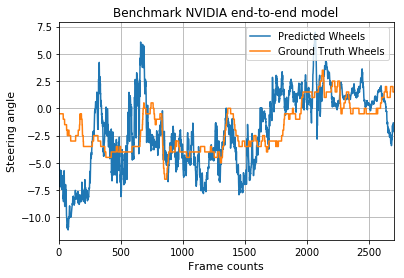

In [7]:
### <1> NVIDIA end-to-end model：Benchmark (基准模型)

# 载入模型
from keras.models import load_model
import preprocess_data
import matplotlib.pyplot as plt

# 载入模型
model = load_model('./models/nvidia_model.h5')   

#载入测试数据
test_imgs, test_wheels = preprocess_data.load_data('test')
test_imgs = preprocess_data.nomorlize_image(test_imgs)

#用模型生成预测转向角度
predicted_wheels = model.predict(test_imgs, batch_size=128, verbose=0)

#生成时间序列图
plt.figure
plt.title('Benchmark NVIDIA end-to-end model')
plt.plot(predicted_wheels)
plt.plot(test_wheels)
plt.ylabel('Steering angle', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Predicted Wheels', 'Ground Truth Wheels'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig('./images/img/1_benchmark.png', dpi=300)
plt.show()

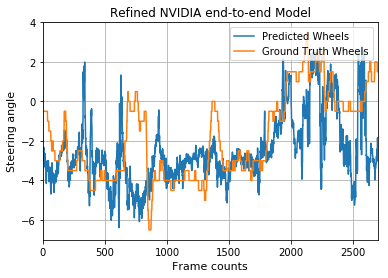

In [8]:
### <2> NVIDIA end-to-end model：Refined Model (改进模型)

# 载入模型
model = load_model('./models/nvidia_refined_model.h5')   

#用模型生成预测转向角度
predicted_wheels = model.predict(test_imgs, batch_size=128, verbose=0)

#生成时间序列图
plt.figure
plt.title('Refined NVIDIA end-to-end Model')
plt.plot(predicted_wheels)
plt.plot(test_wheels)
plt.ylabel('Steering angle', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Predicted Wheels', 'Ground Truth Wheels'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig('./images/img/2_refined.png', dpi=300)
plt.show()

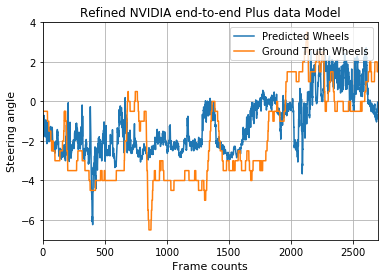

In [9]:
### <3> NVIDIA end-to-end model：Refined Model + 转向角度数据增加

# 载入模型
model = load_model('./models/nvidia_ra_model.h5')   

#用模型生成预测转向角度
predicted_wheels = model.predict(test_imgs, batch_size=128, verbose=0)

#生成时间序列图
plt.figure
plt.title('Refined NVIDIA end-to-end Plus data Model')
plt.plot(predicted_wheels)
plt.plot(test_wheels)
plt.ylabel('Steering angle', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Predicted Wheels', 'Ground Truth Wheels'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig('./images/img/3_ra.png', dpi=300)
plt.show()

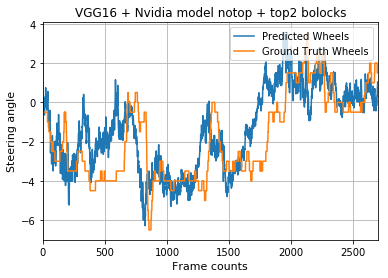

In [10]:
### <4> VGG16 + Nvidia model：notop + top2 bolocks

# 载入模型
model = load_model('./models/vgg16_model.h5')   

#用模型生成预测转向角度
predicted_wheels = model.predict(test_imgs, batch_size=128, verbose=0)

#生成时间序列图
plt.figure
plt.title('VGG16 + Nvidia model notop + top2 bolocks')
plt.plot(predicted_wheels)
plt.plot(test_wheels)
plt.ylabel('Steering angle', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Predicted Wheels', 'Ground Truth Wheels'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig('./images/img/4_vgg16.png', dpi=300)
plt.show()

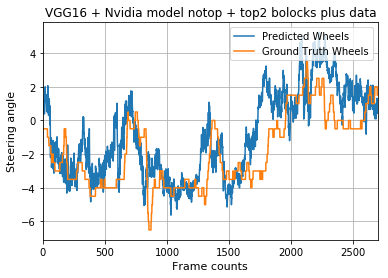

In [11]:
### <5> VGG16 + Nvidia model：notop + top2 bolocks + 转向角度数据增加

# 载入模型
model = load_model('./models/vgg16_add_model.h5')   

#用模型生成预测转向角度
predicted_wheels = model.predict(test_imgs, batch_size=128, verbose=0)

#生成时间序列图
plt.figure
plt.title('VGG16 + Nvidia model notop + top2 bolocks plus data')
plt.plot(predicted_wheels)
plt.plot(test_wheels)
plt.ylabel('Steering angle', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Predicted Wheels', 'Ground Truth Wheels'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig('./images/img/5_vgg16ad.png', dpi=300)
plt.show()

**分析**：从上面各模型的时间序列图可以看出，后两个VGG16+Nvidia model 明显比前三个Nvidia model输出的角度更平滑和贴合原始方向角度，同时从Part3各模型的'test loss'也可以看出后两个模型更出色。所以应该选用VGG16+Nvidia model，虽然'VGG16 + Nvidia model：notop + top2 bolocks'比'VGG16 + Nvidia model：notop + top2 bolocks + 转向角度数据增加'输出的'test loss'要小，但从图中可以看出，后者明显比前者的图形走势更接近于原始的数据走势，所以个人认为最佳的模型应该为最后一个模型'VGG16 + Nvidia model：notop + top2 bolocks + 转向角度数据增加'。

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2.生成结果视频
</p>

**策略**：
* 1.修改./params.py文件中图片宽，高为'80'。
* 2.在./run.py文件中增加‘nomorlize_image()’函数，并在'img_pre_process()'中调用。
* 3.将./utils.py中'get_model'修改为载入vgg16_add_model.h5'和'vgg16_add_model.json'(405和406行)。运行'python run.py'命令生成视频
* 5.生成视频保存于./output文件夹中'epoch10_human_machine.mp4'文件

说明：首次运行时出现两个错误：1.需要下载'openh264-1.6.0-win64msvc.dll'文件放入项目文件根目录下（已解决）。2.修改./utils中'mkv_to_mp4()'函数适用于Windows 10系统，具体见./utils文件（已解决）

In [1]:
### 输出视频
from IPython.display import HTML
output = './output/epoch10_human_machine.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))